# Final Project

# Perkenalan

>- Nama      : Alsello Diveni Manuputty
>- Batch     : HCK 6 Pondok Indah
>- Phase     : 2
---
---
**Objective**
>Pada notebook ini akan dilakukan pengerjaan Final Project dimana akan dibuat model *Classification* untuk memprediksi `status` resiko hutang menggunakan dataset dari [link](https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset) ini. Pada kasus ini, analis ditugaskan untuk membuatkan sebuah model untuk memprediksi dari data yang berisi informasi umum dari *`debitur`*. Karena resiko salah klasifikasi sangat fatal, maka perlu dilakukan *modelling* dengan berusaha untuk meningkatkan *`accuracy`* model. Namun, dari hasil screening awal ternyata proporsi datanya tidak setara. Hal ini akan menjadi masalah nantinya saat pembuatan model. Dengan model ini, diharapkan bank bisa meringankan kerja tim analisis resiko dalam proses screening dan bisa mengarahkan energi yang tersisa ke pekerjaan lain yang memang butuh seorang manusia untuk melakukannya.

# Import Dependencies

Sebelum pengerjaan dimulai, akan diimport dulu segala kebutuhan untuk menyelesaikan notebook ini.

In [1]:
import pandas as pd
import seaborn as sns
sns.set(rc ={'figure.figsize':(25,7)})
from termcolor import cprint 
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor

from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score,KFold
from imblearn.over_sampling import SMOTENC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix


import warnings
warnings.filterwarnings(action='ignore')

In [2]:
pd.set_option('display.max_columns', None)

# Data Loading

Setelah sudah di-import, langsung saja akan dilakukan loading data. Pada bagian ini juga akan digunakan serangkaian cara untuk mendapatkan overview data.

In [3]:
dictionary = pd.read_excel('LCDataDictionary.xlsx', sheet_name= 'LoanStats')
dictionary

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee
...,...,...
75,acc_now_delinq,The number of accounts on which the borrower i...
76,tot_coll_amt,Total collection amounts ever owed
77,tot_cur_bal,Total current balance of all accounts
78,NaN,NaN


In [4]:
df = pd.read_csv('loan.csv')
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def columns_types(dataset):
    #fungsi columns_types akan mencetak dtypes yang berbeda yang tersedia di semua kolom
    int_col = len(dataset.select_dtypes('int').columns)
    float_col = len(dataset.select_dtypes('float').columns)
    object_col = len(dataset.select_dtypes('object').columns)
    print('Terdapat {} int, {} float dan {} object type features di data'.format(int_col, float_col, object_col-1))

columns_types(df)

Terdapat 2 int, 49 float dan 22 object type features di data


Karena jumlah kolom dari data mentah nya banyak, maka akan saya manfaatkan data dictionary yang sudah tersedia dari pemilik data. Akan saya langsung tunjukkan saja untuk memudahkan pemahaman saat ditengah pengerjaan.

In [6]:
def description(column_name):
    #function description untuk menjelaskan arti dari kolom
    return dictionary.loc[dictionary.LoanStatNew == column_name].Description.values[0]

def print_description(column_list):
    #function print_description print arti dan persentase missing value dari fitur
    for i, column in enumerate(column_list):
        color = 'grey'
        if column == 'loan_status':
            color = 'green'
        try:
            cprint("[{}]:{}={} [{}% Null]".format(i,column, description(column), (df[column].isna().sum()/len(df))*100), color)
        except Exception as e:
            cprint("[{}]:{}".format(i, column), 'red')
            
cols = df.columns
print_description(cols)

[0]:id=A unique LC assigned ID for the loan listing. [0.0% Null]
[1]:member_id=A unique LC assigned Id for the borrower member. [0.0% Null]
[2]:loan_amnt=The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. [0.0% Null]
[3]:funded_amnt=The total amount committed to that loan at that point in time. [0.0% Null]
[4]:funded_amnt_inv=The total amount committed by investors for that loan at that point in time. [0.0% Null]
[5]:term=The number of payments on the loan. Values are in months and can be either 36 or 60. [0.0% Null]
[6]:int_rate=Interest Rate on the loan [0.0% Null]
[7]:installment=The monthly payment owed by the borrower if the loan originates. [0.0% Null]
[8]:grade=LC assigned loan grade [0.0% Null]
[9]:sub_grade=LC assigned loan subgrade [0.0% Null]
[10]:emp_title=The job title supplied by the Borrower when applying for the loan.* [5.799325879922783% Null]
[11]:

Sebagai filter pertama, untuk kolom yang terdiri dari data kosong sebanyak lebih dari 97% akan dibuang saja. Hal ini karena data yang kosong tidak berguna bagi permodelan ataupun analisis.

In [7]:
#drop missing value diatas 97%
for col in df.columns:
    if ((df[col].isna().sum()/len(df))*100) >= 97:
        df = df.drop([col], axis=1)
        
columns_types(df)

Terdapat 2 int, 33 float dan 21 object type features di data


Karena data masih memiliki banyak kolom, disini saya akan dilakukan filter data kedua yaitu seleksi berdasarkan pengetahuan saya soal kredit. Dari sini akan diuraikan kolom-kolom yang terpilih beserta alasannya

| Column Name      			| Explanation                                                            |
|---------------------------|------------------------------------------------------------------------|
| addr_state				| Area domisili bisa memberi pengaruh kepada pembayaran hutang berdasarkan kondisi ekonomi, lapangan pekerjaan, dsb.       |
| annual_inc       			| Pendapatan debitur adalah faktor penting dalam menilai kemampuan pembayarannya.  |
| application_type 			| Perbedaan tipe aplikasi seperti individual atau joint memiliki kemungkinan berpengaruh terhadap resiko.     |
| delinq_2yrs	   			| Jumlah kategori pembayaran 'delinquent' dalam 2 tahun kebelakang bisa menentukan pola kebiasaan membayar debitur.|
| dti	   					| Rasio Debt-to-Income dapat mengukur kestabilan finansial debitur.													|
| emp_length	   			| Lama bekerja debitur bisa mengukur kestabilan pekerjaan yang berpengaruh kepada kemampuan membayarnya				|
| grade	   					| Penggolongan grade adalah penilaian resiko kredit dari kreditur 
|          					|Grade A: Resiko rendah, diprediksi menguntungkan dan debitur dengan kekuatan finansial yang baik.
|          					|Grade B: Resiko menengah dengan status kredit yang baik.
|          					|Grade C: Resiko menengah hingga tinggi dengan beberapa indikator kredit beresiko.
|          					|Grade D: Resiko tinggi dengan profil kredit yang lebih lemah.
|          					|Grade E: Resiko tinggi dengan riwayat kredit terbatas atau memiliki indikator kredit beresiko dalam jumlah tinggi.
|          					|Grade F: Resiko tinggi dengan riwayat kredit yang buruk seperti jumlah hutang yang tinggi, dan pembayaran yang terlambat
|          					|Grade G: Resiko tertinggi dengan riwayat kredit yang sangat buruk dan masalah kredit lainnya yang lebih berat.
| home_ownership			| Dapat menggambarkan kestabilan situasi finansial debitur.
| inq_last_6mths	   		| Menggambarkan aktivitas kredit debitur belakangan ini.
| int_rate	   				| Dapat berkorelasi dengan tingkat resiko debitur.
| purpose	   				| Dapat memprediksi komitmen membayar debitur.
| revol_util	   			| Menunjukan berapa kredit yang tersedia untuk debitur
| term	   					| Dapat berpengaruh ke kemampuan debitur dalam mengelola pembayaran.
| total_acc	   				| Jumlah total pinjaman dapat memberikan informasi mengenai riwayat kredit debitur.
| acc_now_delinq	   		| Jumlah akun yang saat ini menunggak dapat mengindikasikan masalah kredit yang sedang berlangsung.
| tot_cur_bal	   			| Dapat mencerminkan beban kredit peminjam secara keseluruhan.
| pub_rec					| Jumlah catatan publik seperti bangkrut, repo, pajak dapat mempengaruhi kelayakan kredit.
| mths_since_last_delinq	| Dapat menggambarkan kebiasaan membayar debitur belakangan ini.
| mths_since_last_record	| Dapat menggambarkan resiko kredit
| total_pymnt	 			| Menggambarkan riwayat pembayaran.
| open_acc	   				| Dapat mengindikasikan aktivitas kredit debitur.
| collections_12_mths_ex_med| Dapat menggambarkan masalah kredit belakangan ini.
| loan_amnt	   				| Mungkin berkorelasi dengan resiko itu sendiri.
| recoveries	   			| Mungkin berkorelasi dengan kredit macet(Default)
| verification_status	  	| Dapat mengindikasikan keaslian laporan keuangan debitur.
| loan_status				| Target Prediksi

Dapat dilihat dari uraian diatas bahwa saya hanya memilih kolom-kolom yang sekiranya memang menggambarkan analisa kreditnya. Beberapa kolom seperti address, grade atau apapun yang sekiranya dapat memberi unsur diskriminasi hanya dipakai untuk keperluan eksplorasi datanya saja. Kalaupun nantinya tidak digunakan dalam model, nanti akan dibuang.

# Exploratory Data Analysis

Pada bagian ini akan dilakukan proses analisis data. Dari sini akan ditemukan beberapa fakta baru mengenai pola ataupun deskripsi data yang jika memungkinkan pemahaman datanya bisa dimanfaatkan untuk membuat kolom baru berisi representasi informasi yang mungkin nantinya juga tidak dipilih untuk pembuatan model prediksi.

Sebelum mulai alangkah baiknya jika dibuat data baru untuk menghindari kontaminasi proses yang menyebabkan datanya berubah.

In [8]:
df_eda = df.copy()

Untuk eksplorasi data, akan digunakan kolom yang sudah terpilih dan kolom id untuk membantu analisa data secara spesifik.

In [9]:
df_eda = df_eda[['id','issue_d','addr_state','annual_inc','application_type','delinq_2yrs','dti','emp_length',
                 'grade','home_ownership','inq_last_6mths','int_rate','purpose','revol_util',
                 'term','total_acc','acc_now_delinq','tot_cur_bal','pub_rec',
                 'mths_since_last_delinq','mths_since_last_record','total_pymnt','open_acc',
                 'collections_12_mths_ex_med','loan_amnt','recoveries','verification_status','loan_status']]

In [10]:
df_eda

,id,issue_d,addr_state,annual_inc,application_type,delinq_2yrs,dti,emp_length,grade,home_ownership,inq_last_6mths,int_rate,purpose,revol_util,term,total_acc,acc_now_delinq,tot_cur_bal,pub_rec,mths_since_last_delinq,mths_since_last_record,total_pymnt,open_acc,collections_12_mths_ex_med,loan_amnt,recoveries,verification_status,loan_status
0,1077501,Dec-2011,AZ,24000.0,INDIVIDUAL,0.0,27.65,10+ years,B,RENT,1.0,10.65,credit_card,83.7,36 months,9.0,0.0,NaN,0.0,NaN,NaN,5861.071414,3.0,0.0,5000.0,0.00,Verified,Fully Paid
1,1077430,Dec-2011,GA,30000.0,INDIVIDUAL,0.0,1.00,< 1 year,C,RENT,5.0,15.27,car,9.4,60 months,4.0,0.0,NaN,0.0,NaN,NaN,1008.710000,3.0,0.0,2500.0,117.08,Source Verified,Charged Off
2,1077175,Dec-2011,IL,12252.0,INDIVIDUAL,0.0,8.72,10+ years,C,RENT,2.0,15.96,small_business,98.5,36 months,10.0,0.0,NaN,0.0,NaN,NaN,3003.653644,2.0,0.0,2400.0,0.00,Not Verified,Fully Paid
3,1076863,Dec-2011,CA,49200.0,INDIVIDUAL,0.0,20.00,10+ years,C,RENT,1.0,13.49,other,21.0,36 months,37.0,0.0,NaN,0.0,35.0,NaN,12226.302212,10.0,0.0,10000.0,0.00,Source Verified,Fully Paid
4,1075358,Dec-2011,OR,80000.0,INDIVIDUAL,0.0,17.94,1 year,B,RENT,0.0,12.69,other,53.9,60 months,38.0,0.0,NaN,0.0,38.0,NaN,3242.170000,15.0,0.0,3000.0,0.00,Source Verified,Current
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887374,36371250,Jan-2015,CA,31000.0,INDIVIDUAL,0.0,28.69,8 years,B,RENT,0.0,11.99,debt_consolidation,82.1,36 months,15.0,0.0,25274.0,1.0,NaN,77.0,3971.880000,9.0,0.0,10000.0,0.00,Verified,Current
887375,36441262,Jan-2015,NJ,79000.0,INDIVIDUAL,0.0,3.90,10+ years,B,MORTGAGE,1.0,11.99,home_improvement,84.5,36 months,23.0,0.0,140285.0,0.0,26.0,NaN,9532.390000,5.0,0.0,24000.0,0.00,Verified,Current
887376,36271333,Jan-2015,TN,35000.0,INDIVIDUAL,0.0,30.90,5 years,D,RENT,0.0,15.99,debt_consolidation,61.3,60 months,22.0,0.0,34178.0,1.0,NaN,84.0,3769.740000,9.0,0.0,13000.0,0.00,Verified,Current
887377,36490806,Jan-2015,MA,64400.0,INDIVIDUAL,1.0,27.19,1 year,E,RENT,2.0,19.99,debt_consolidation,30.6,60 months,20.0,0.0,58418.0,0.0,22.0,NaN,3787.670000,17.0,1.0,12000.0,0.00,Source Verified,Current


In [11]:
df_eda['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

Dari list diatas terlihat bahwa data memiliki banyak variasi dan tergolong tidak setara(imbalance). Oleh karena itu, nanti akan dicoba untuk dikurangi variasi kelasnya di bagian Feature Engineering. Mungkin kelas ini bisa dibagi menjadi seperti


>1. Issued, Current, Fully Paid, Does not meet the credit policy. Status:Fully Paid (Kategori 1)
>- Current - Semua pembayaran tepat waktu
>- Fully Paid - Semua kewajiban bayar sudah dipenuhi dan hutang sudah selesai
>2. In Grace Period, Late (16-30 days), Late (31-120 days) (Kategori 2)
>- In Grace Period - 1-15 hari terlambat dari jatuh tempo
>- Late (16-30 days) - 16-30 hari terlambat dari jatuh tempo
>- Late (31-120 days) - 31-120 hari terlambat dari jatuh tempo
>3. Charged Off , Does not meet the credit policy. Status:Charged Off, Default (Kategori 3)
>- Default - Tidak bisa melakukan pembayaran dalam jangka waktu yang lama
>- Charged Off - Tim yang bersangkutan sudah memberi label bahwa hutang ini tidak akan bisa dibayar

In [12]:
loan_status_count = df_eda[['id','loan_status']].groupby(['loan_status']).size().reset_index(name = 'count')
total_loans = loan_status_count['count'].sum()
loan_status_count['percentage(%)'] = ((loan_status_count['count'] / total_loans)*100).astype('float')

print(loan_status_count)

                                         loan_status   count  percentage(%)
0                                        Charged Off   45248       5.099061
1                                            Current  601779      67.815330
2                                            Default    1219       0.137371
3  Does not meet the credit policy. Status:Charge...     761       0.085758
4  Does not meet the credit policy. Status:Fully ...    1988       0.224031
5                                         Fully Paid  207723      23.408600
6                                    In Grace Period    6253       0.704659
7                                             Issued    8460       0.953369
8                                  Late (16-30 days)    2357       0.265614
9                                 Late (31-120 days)   11591       1.306206


Dari 9 kategori yang ada pada kolom loan_status, dapat dibagi 2 antara status yang beresiko dan juga yang tidak beresiko.
>Kolom `Charged Off`, `Default` , `Does not meet the credit policy. Status:Charged Off`, `Late (16-30 days)` dan `Late (31-120 days)` adalah kolom yang digolongkan sebagai `beresiko`.
- Dari sini dapat diketahui bahwa ada 6.9% data yang beresiko yang berjumlah 61176 entry data. 
- Diketahui juga ada 93.1% data yang tidak beresiko yang berjumlah sebanyak 826203 entry data.


**Karena objective saya memprediksi Risky Loan, maka untuk EDA akan difokuskan ke data yang beresiko dahulu. Mungkin saja bisa ditemukan akar masalahnya dari eksplorasi ini.**

In [13]:
# membuat variabel baru dari masing2 loan_status
charged_off = df_eda.loc[df_eda['loan_status'] == 'Charged Off']
default = df_eda.loc[df_eda['loan_status'] == 'Default']
nopolicy_charged_off = df_eda.loc[df_eda['loan_status'] == 'Does not meet the credit policy. Status:Charged Off']

Selanjutnya akan dicoba untuk mengamati pengaruh `grade` terhadap loan_status yang beresiko. Dari grade yang sudah dijelaskan pada deskripsi kolom di atas, dapat disimpulkan bahwa resiko meningkat semakin urutan grade nya bertambah. Grade A memiliki resiko paling kecil dan grade G memiliki resiko tertinggi. Mungkin bisa ditemukan hubungan tertentu dari kedua data ini.

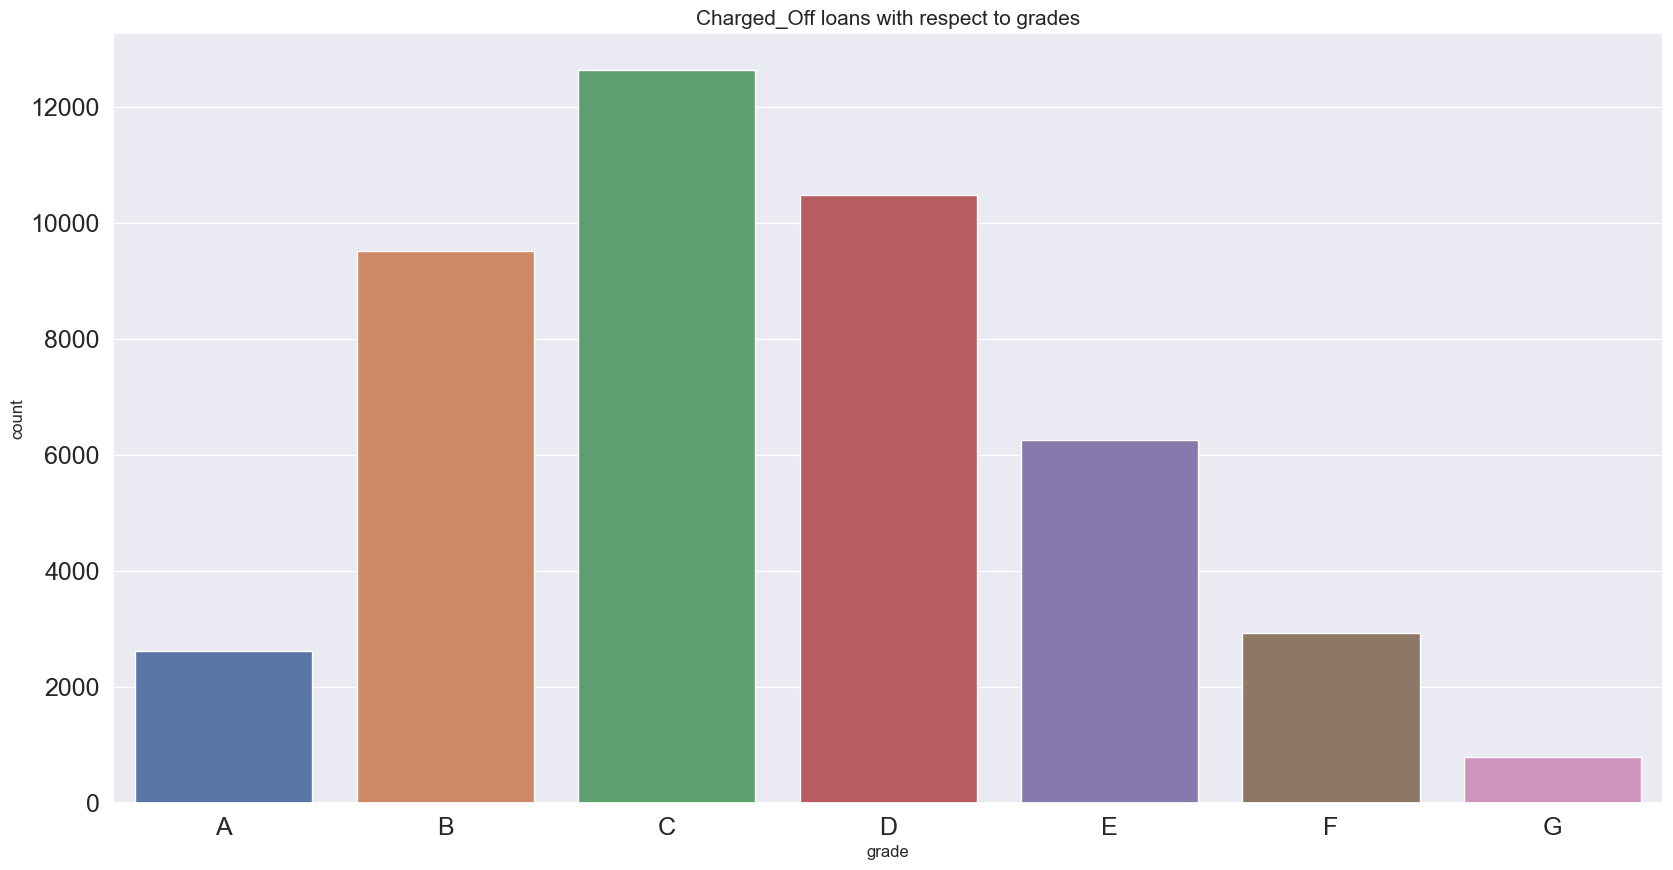

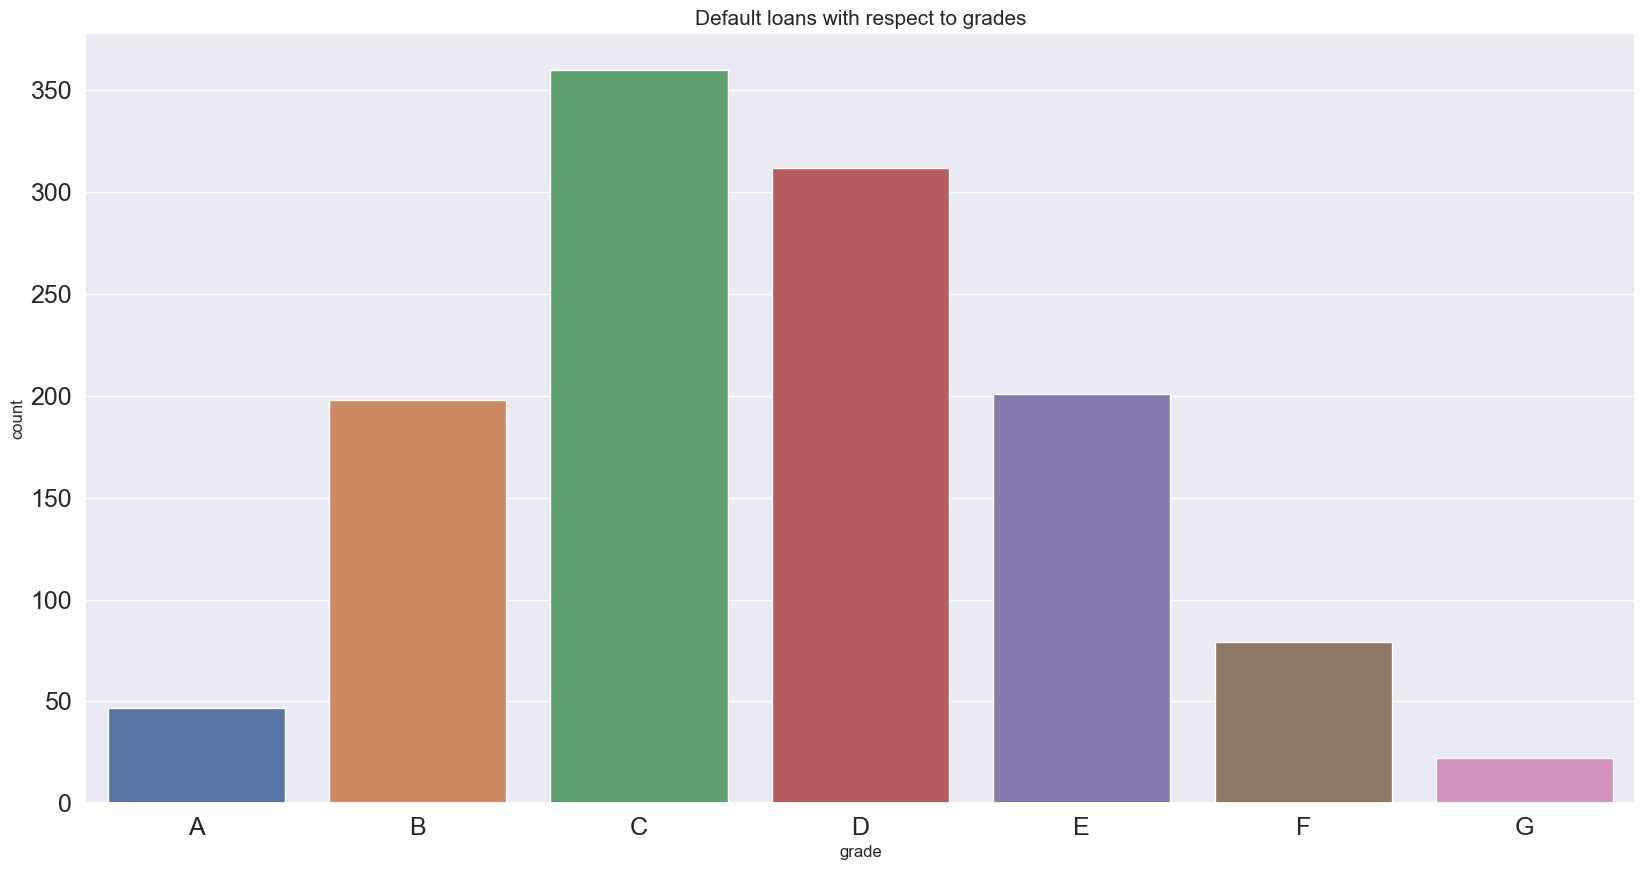

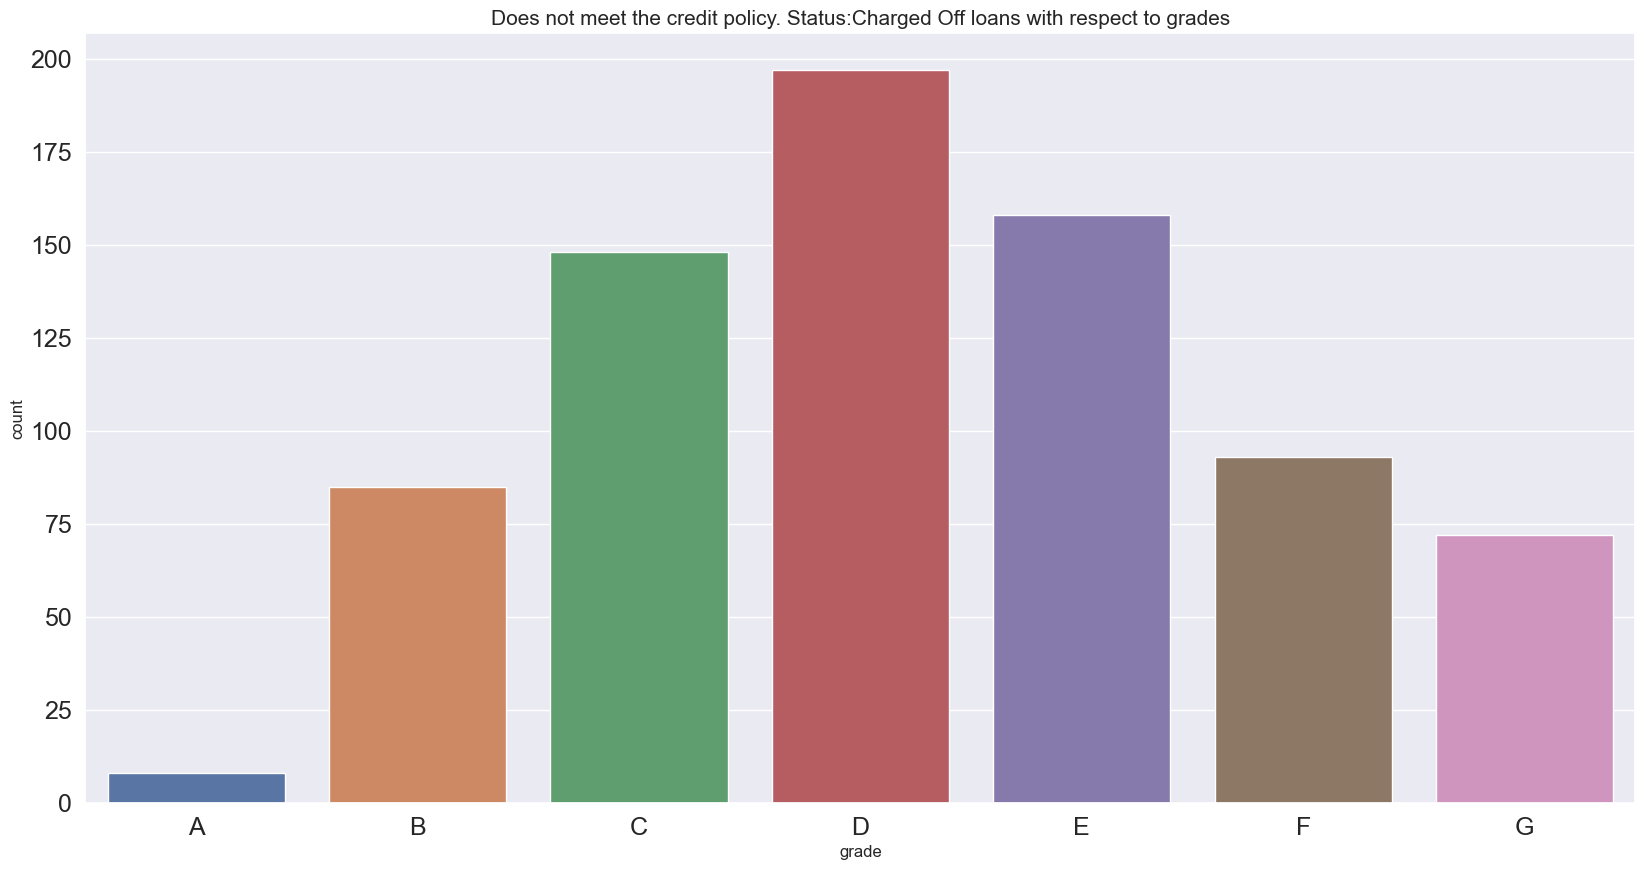

In [14]:
sns.set(rc ={'figure.figsize':(20,10)})
def loan_grade(data, name):
    data_grade = data.groupby(['grade']).size().reset_index(name='count')
    data_grade['percentage_(%)'] = (data_grade['count']/len(data))*100

    sns.barplot(x = 'grade', y = 'count', data = data_grade)
    plt.title('{} loans with respect to grades'.format(name), fontsize = 15)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

loan_grade(charged_off, 'Charged_Off')
loan_grade(default, 'Default')
loan_grade(nopolicy_charged_off, 'Does not meet the credit policy. Status:Charged Off')

Benar saja, ternyata grade memiliki pengaruh terhadap loan_status nya. Hal ini bisa ditunjukan pada pola jumlah debitur dari masing-masing grade terhadap kelas loan_status nya. Dari ketiga visualisasi, tergambar bahwa grade A memiliki jumlah sedikit pada status yang beresiko. Jumlahnya semakin naik hingga grade C atau D yang memang secara pembagiannya, resikonya semakin besar. Penurunan jumlah debitur untuk grade E hingga G kemungkinan dikarenakan dari jumlah debitur yang memang sedikit. **Kecil kemungkinan kreditur untuk menyetujui calon debitur yang beresiko.**

Selanjutnya akan diamati pola dari debitur berdasarkan jumlahnya terhadap tenornya. Dari sini juga akan terlihat ada tenor berapa saja yang disediakan oleh kreditur ini.

In [15]:
terms1 = charged_off.groupby(['term']).size().reset_index(name='count')
terms2 = default.groupby(['term']).size().reset_index(name='count')
terms3 = nopolicy_charged_off.groupby(['term']).size().reset_index(name='count')

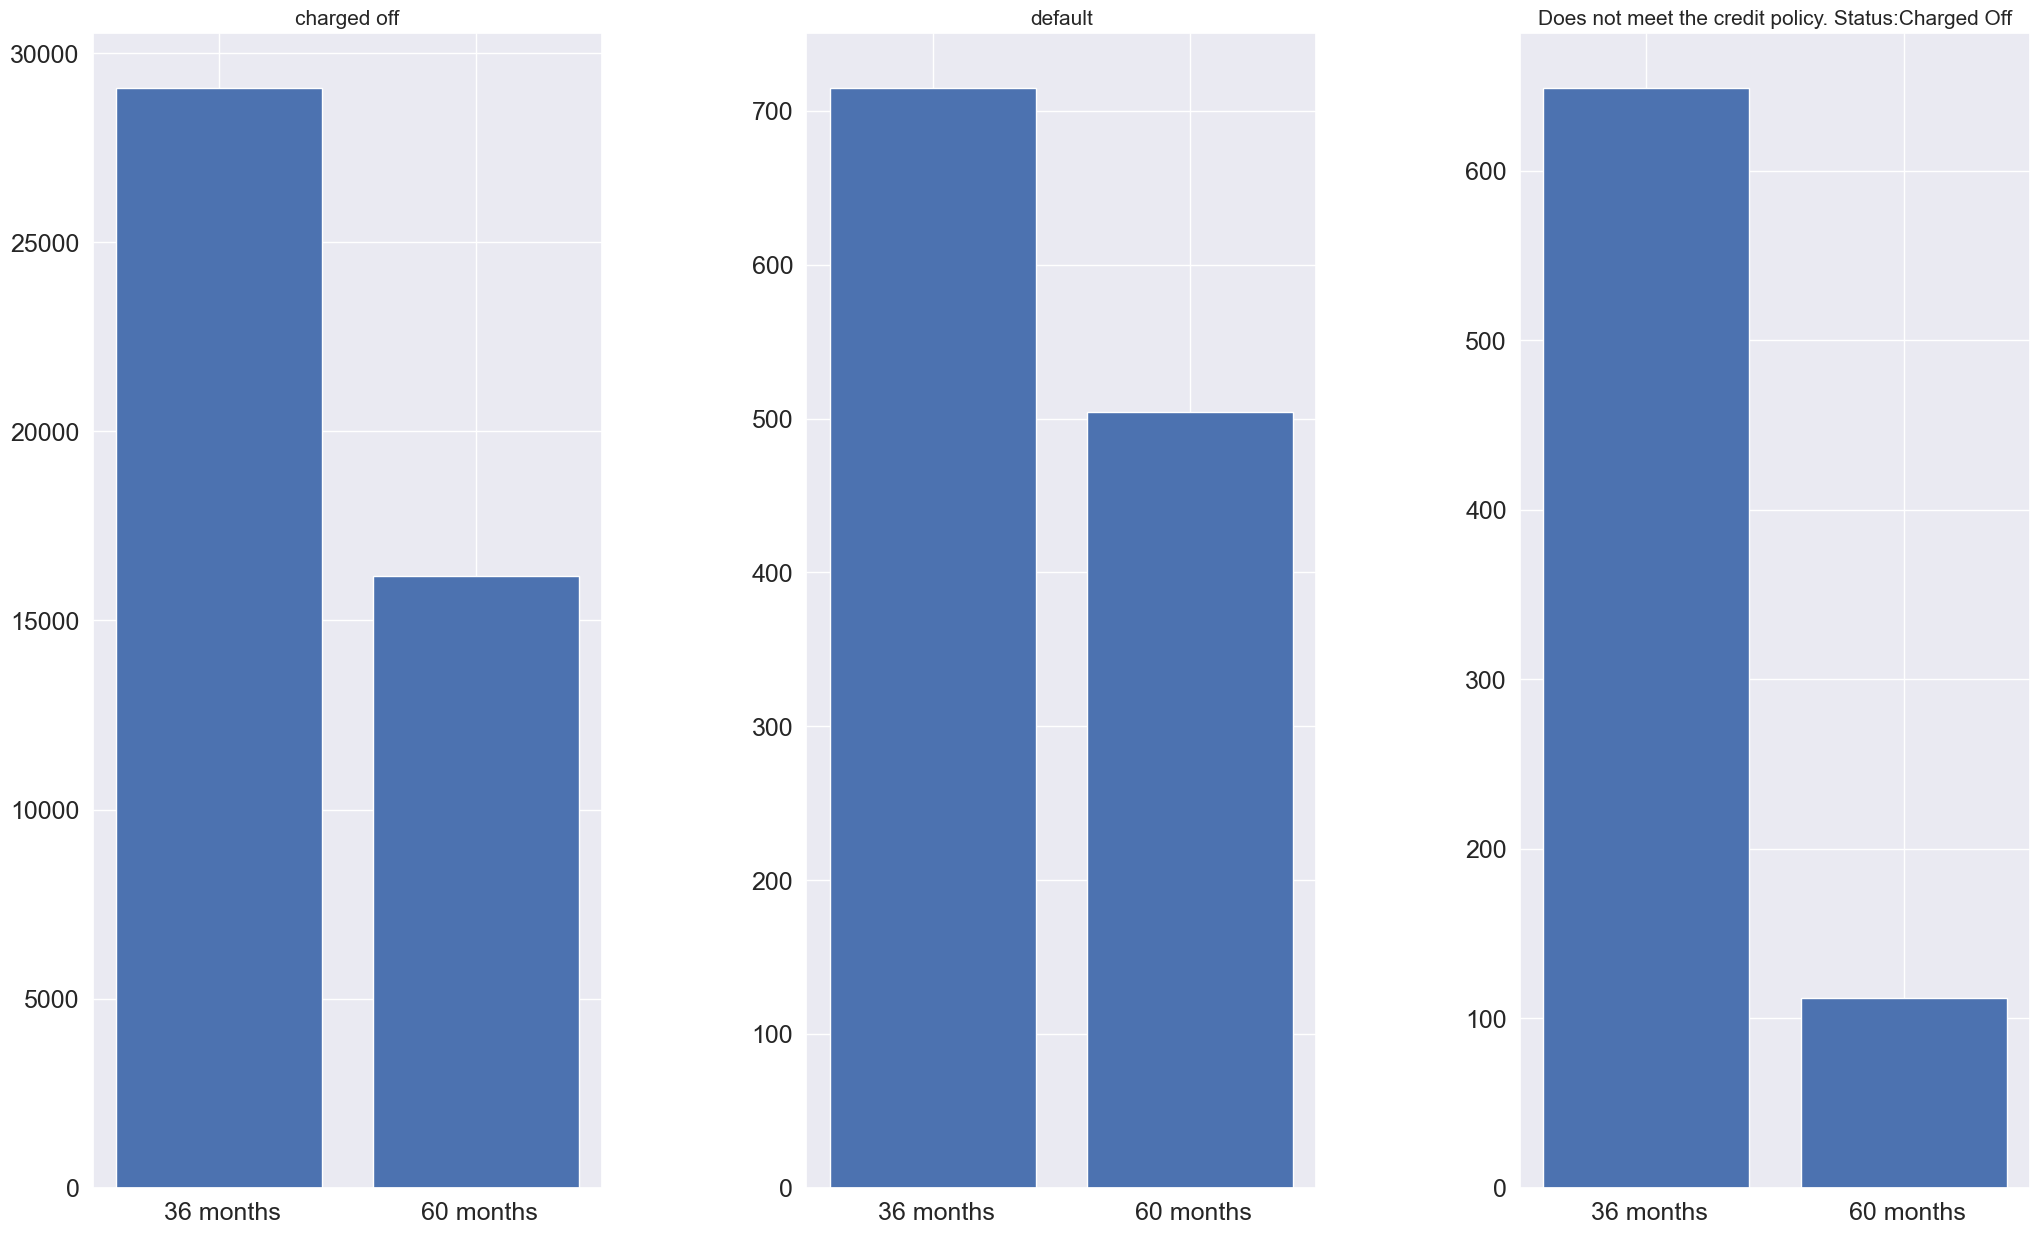

In [16]:
figure, axis = plt.subplots(1, 3, figsize=(25,15))
axis[0].bar(x = 'term', height = 'count', data = terms1)
axis[0].set_title('charged off', fontdict = {'fontsize':15})
axis[0].tick_params(labelsize=18)

axis[1].bar(x = 'term', height = 'count', data = terms2)
axis[1].set_title('default',fontdict = {'fontsize':15})
axis[1].tick_params(labelsize=18)

axis[2].bar(x = 'term', height = 'count', data = terms3)
axis[2].set_title('Does not meet the credit policy. Status:Charged Off',fontdict = {'fontsize':15})
axis[2].tick_params(labelsize=18)
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plt.show()

Setelah divisualisasikan, terlihat bahwa kreditur menyediakan 2 pilihan tenor. Tenor 36 bulan, dan juga 60 bulan. Ditemukan fakta baru juga bahwa umumnya, debitur lebih memilih tenor yang singkat dibanding yang lama. Hal ini mungkin karena debitur yang sudah sadar akan perbedaan jumlah bunga dari masing-masing tenor dimana untuk tenor yang lebih lama, bunga nya akan semakin banyak.

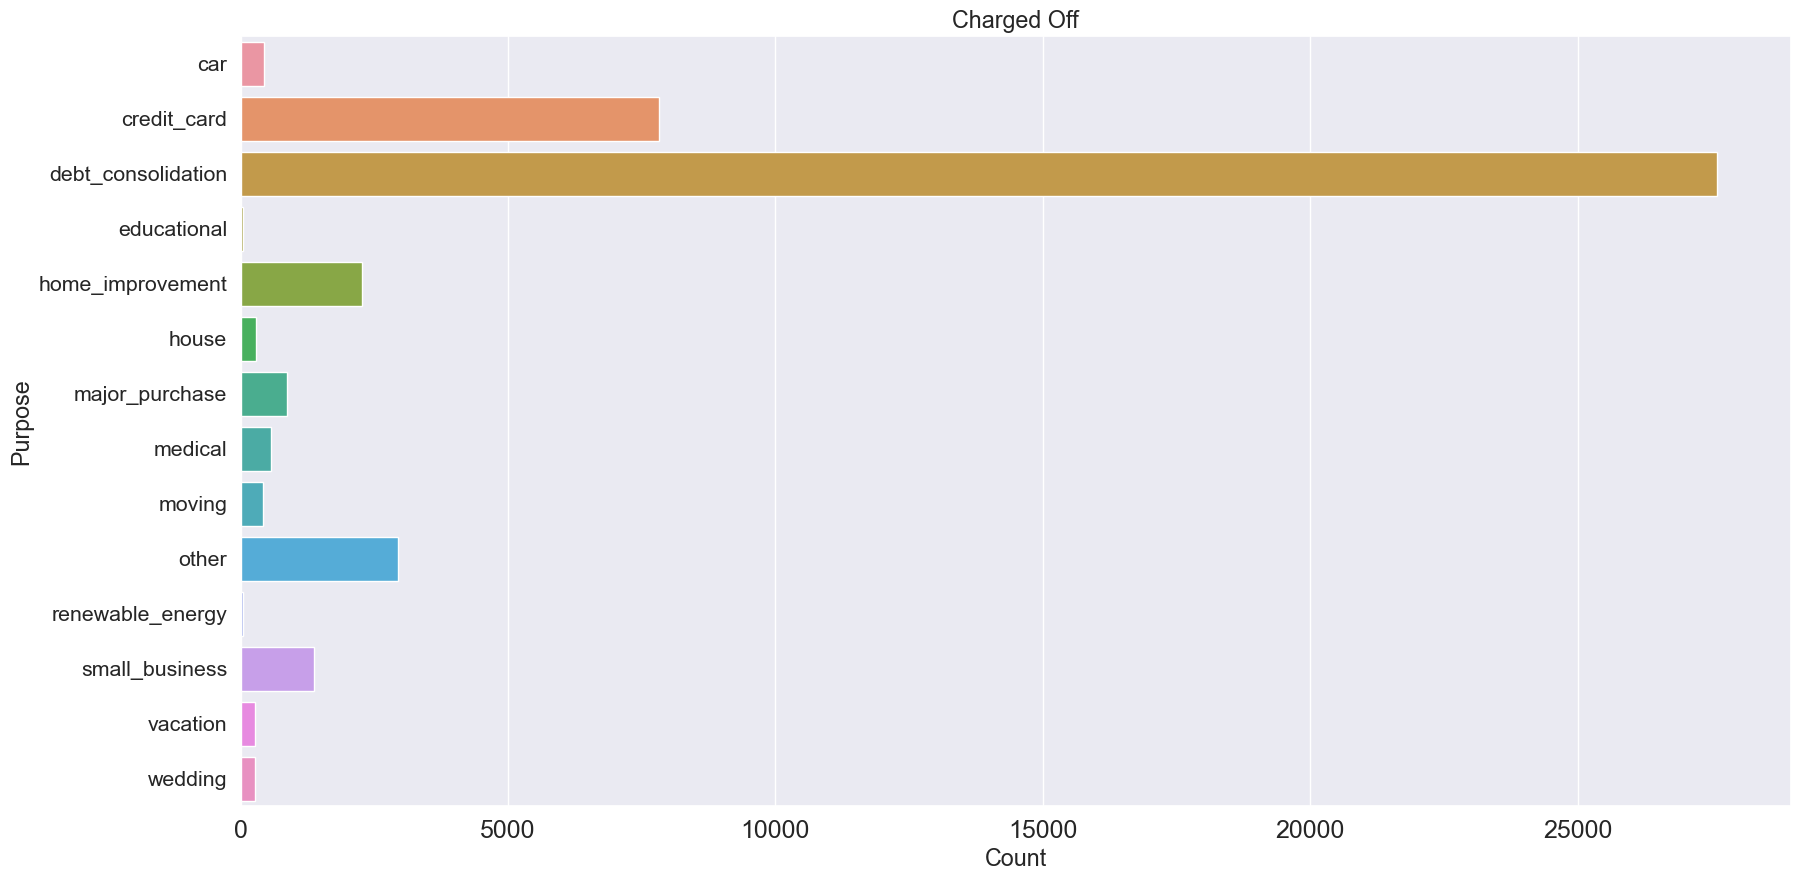

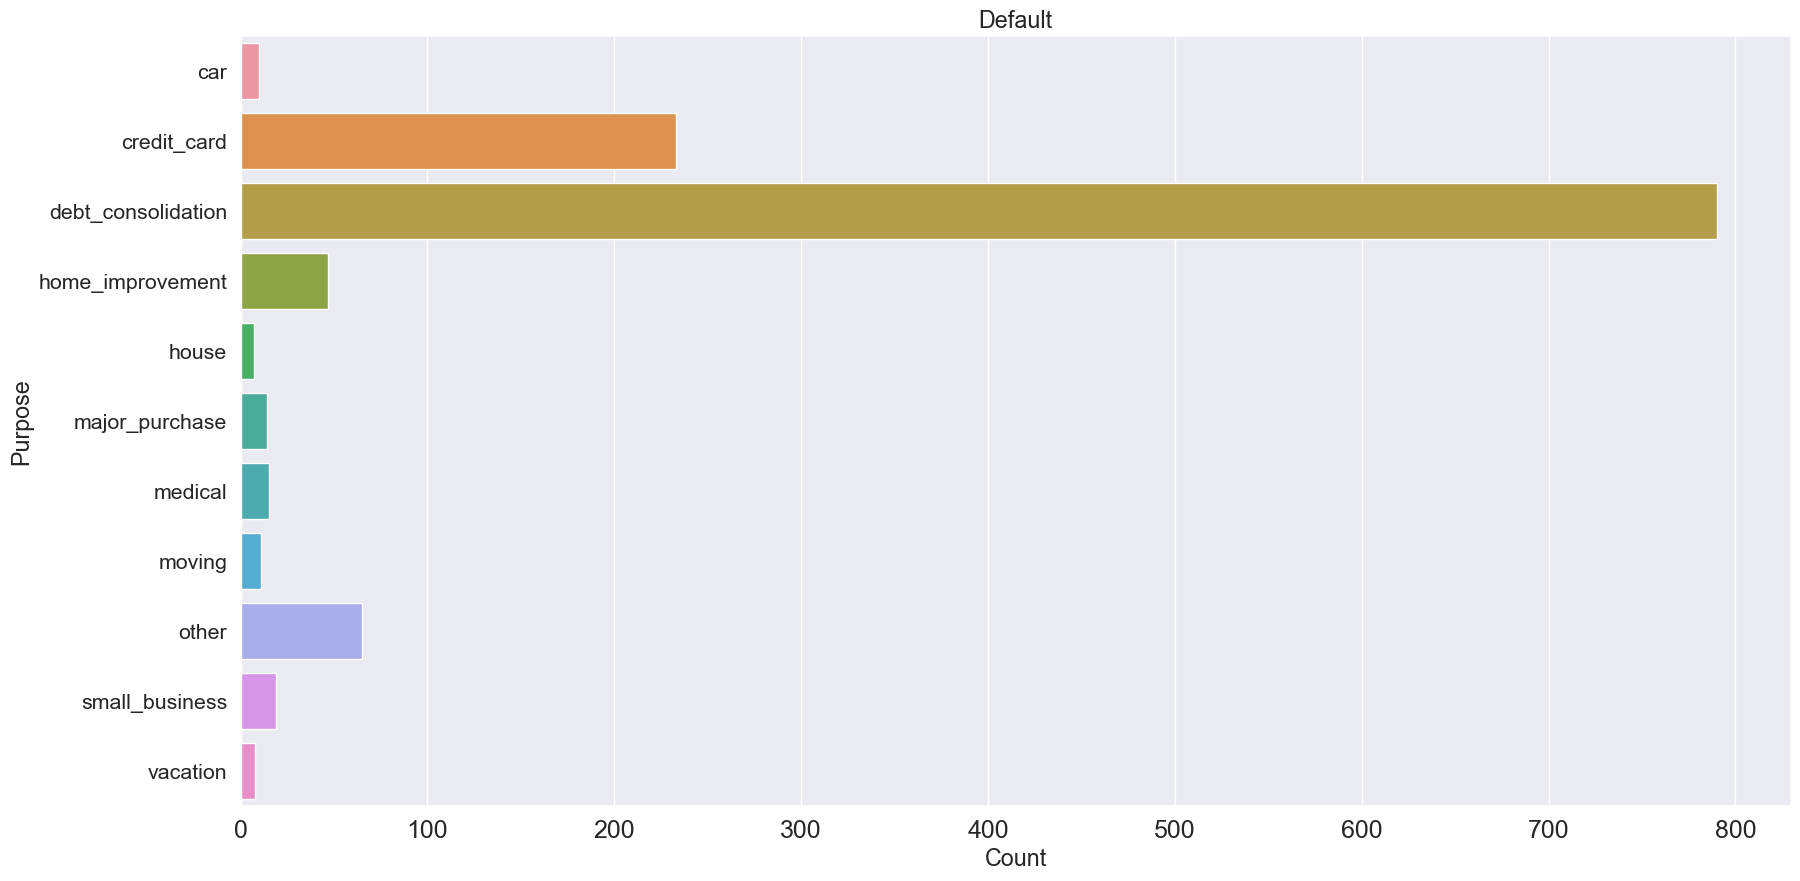

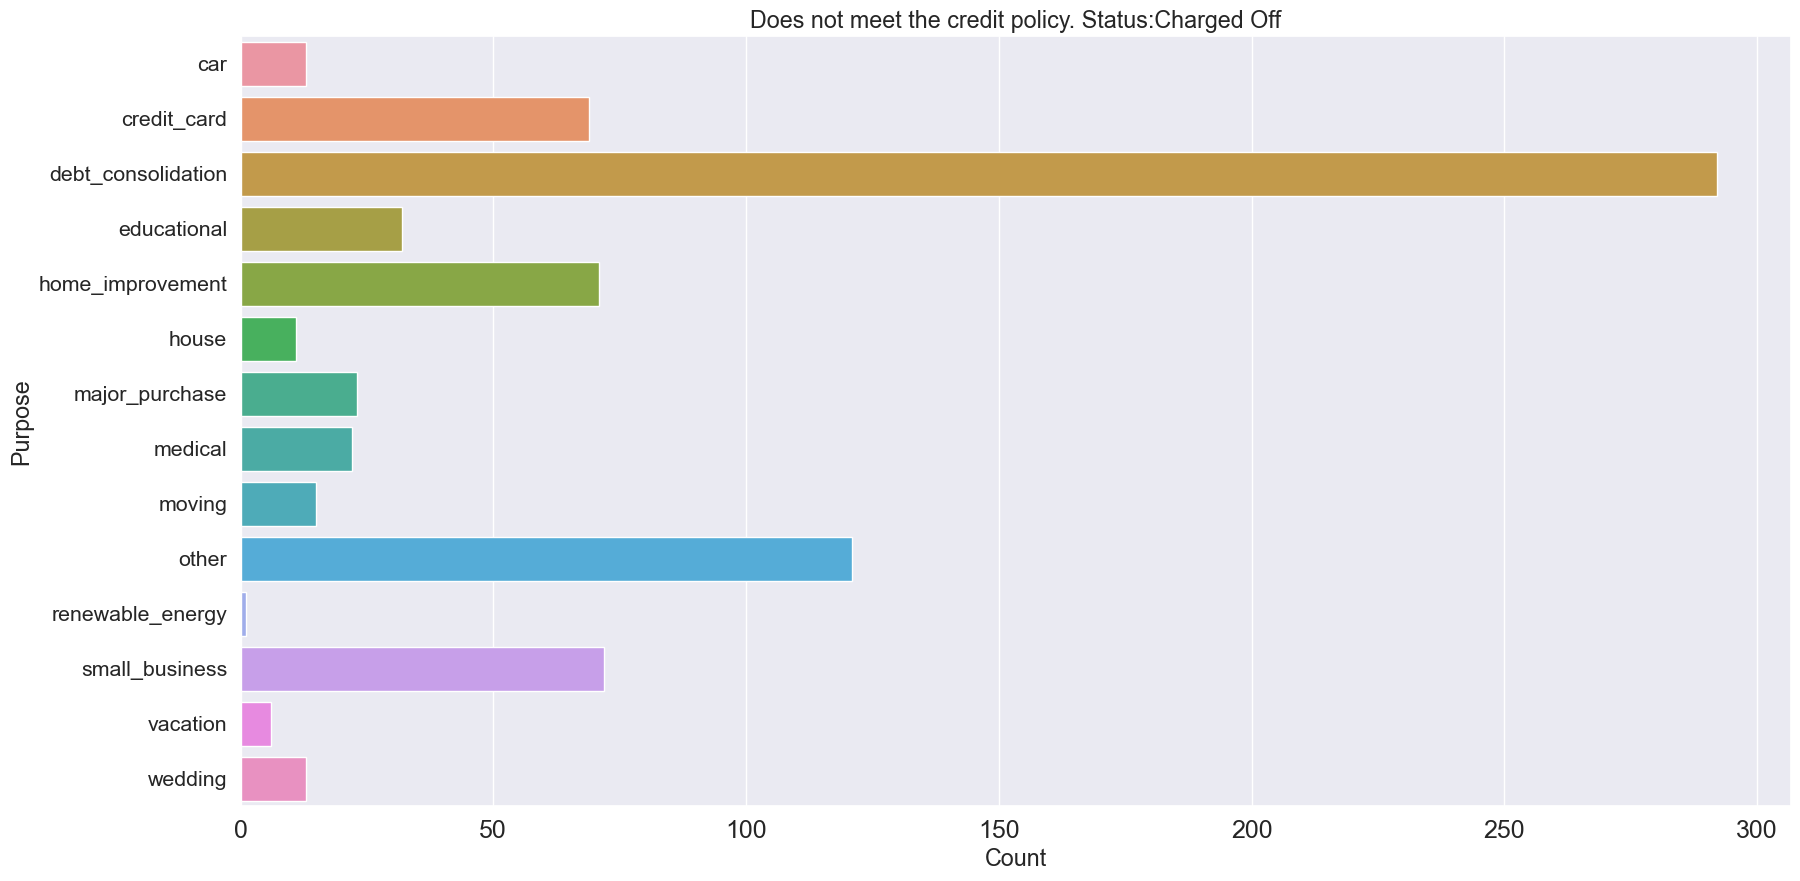

In [17]:
def loan_purpose(data, target_status):
    target_data = data[data['loan_status'] == target_status]
    purpose_counts = target_data.groupby(['purpose']).size().reset_index(name='count')
    purpose_counts['percentage_(%)'] = (purpose_counts['count'] / len(target_data)) * 100

    sns.set(rc={'figure.figsize': (20, 10)})
    sns.set(font_scale=1.4)
    sns.barplot(x='count', y='purpose', data=purpose_counts)
    plt.title(target_status)
    plt.xticks(fontsize=18)
    plt.xlabel('Count')
    plt.ylabel('Purpose')
    plt.show()

loan_purpose(charged_off, 'Charged Off')
loan_purpose(default, 'Default')
loan_purpose(nopolicy_charged_off, 'Does not meet the credit policy. Status:Charged Off')

In [18]:
df_eda['purpose'].value_counts()

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

Dari visualisasi, terlihat bahwa dari masing-masing status, debitur menggunakan layanan kredit ini untuk debt_consolidation.
Berdasarkan teorinya, debt consolidation adalah strategi finansial dimana debitur membuat hutang baru, untuk membayar beberapa hutang yang sedang berlangsung. Tujuan utamanya adalah memudahkan pembayaran serta tenor yang lebih lama. Secara awamnya, debt consolidation adalah menyatukan beberapa hutang menjadi satu. Strategi ini baik untuk orang-orang yang memiliki hutang di beberapa tempat, dan ketika dihitung, jumlah bunga yang harus dibayarkan lebih sedikit dari yang seharusnya membayar bunga ke beberapa tempat menjadi membayar ke satu tempat. Realitanya, banyak sekali debitur yang memilih opsi ini ketika mereka sudah di ujung tanduk pada kredit yang sedang dijalaninya, dan akhirnya malah memilih opsi ini walaupun bunga nya lebih tinggi. Akhirnya hutang menumpuk dan akhirnya tidak mampu membayar.

Selanjutnya akan diamati hubungan-hubungan addr_state dengan kolom lainnya. Untuk itu, kolom ini akan di-handling dahulu untuk memperluas scope pengamatan. Handling disini akan dilakukan dengan cara memasukan daftar negara bagian ini terhadap regionnya.

In [19]:
df_eda['addr_state'].unique()

# list region beserta statenya.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    


df_eda['region'] = df_eda['addr_state'].apply(finding_regions)

Sebagai tambahan analisa, diperlukan kolom tahun untuk memperlihatkan perkembangan perusahaan kreditur secara bisnisnya.

In [20]:
# ambil tahun dari issue_d
df_eda['issue_d'].head()
dt_series = pd.to_datetime(df_eda['issue_d'])
df_eda['year'] = dt_series.dt.year

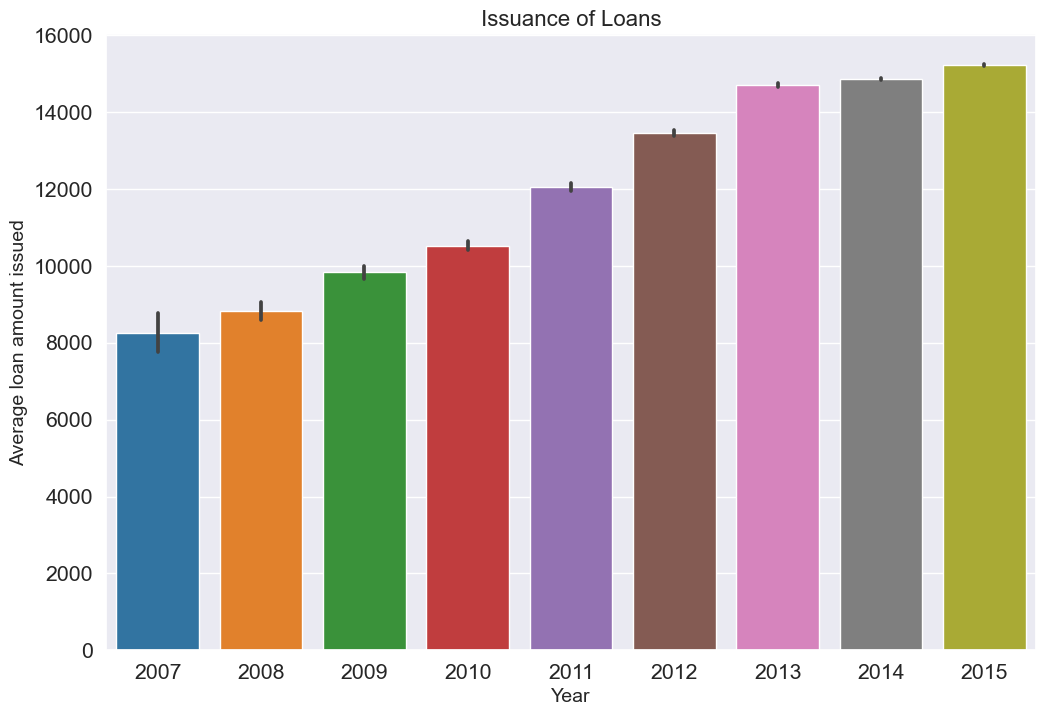

In [21]:
plt.figure(figsize=(12, 8))
sns.barplot(x='year', y='loan_amnt', data=df_eda, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)
plt.show()

Untuk kolom emp_length, data masih berbentuk object dan juga data memiliki missing value. Disini akan diatasi dengan cara mengganti data menjadi integer dan untuk sel yang kosong akan dibuat menjadi 0. Karena itu, sel yang memiliki informasi < 1 year juga akan diganti menjadi 0.5 saja.

In [22]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'nan']

# buat kolom baru dan mengganti tipe data menjadi integer

lst = [df_eda]
df_eda['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'nan', "emp_length_int"] = 0

In [23]:
df_eda['emp_length_int'].unique()

array([10. ,  0.5,  1. ,  3. ,  8. ,  9. ,  4. ,  5. ,  6. ,  2. ,  7. ,
        nan])

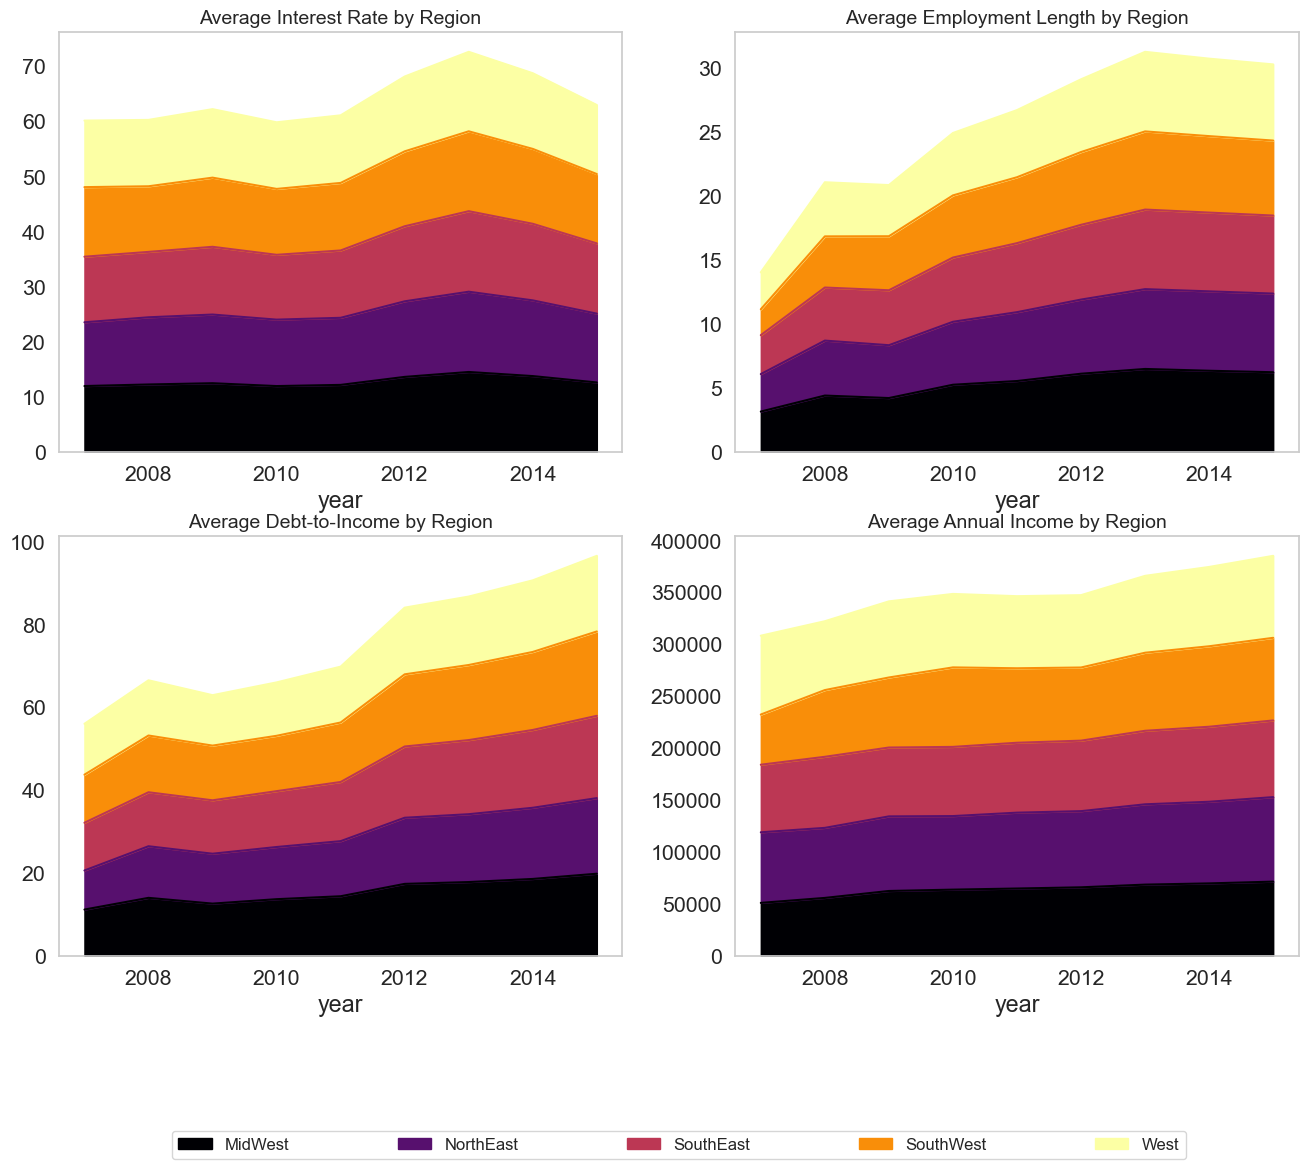

In [24]:
sns.set_style('whitegrid')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.inferno

by_interest_rate = df_eda.groupby(['year', 'region']).int_rate.mean()
by_interest_rate.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)


by_employment_length = df_eda.groupby(['year', 'region']).emp_length_int.mean()
by_employment_length.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)

by_dti = df_eda.groupby(['year', 'region']).dti.mean()
by_dti.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

by_income = df_eda.groupby(['year', 'region']).annual_inc.mean()
by_income.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, ax=ax4, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.5, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)

Dari visualisasi diatas, terlihat bahwa region **West**, **SouthWest**, dan **SouthEast** dominan dari keseluruhan data. Kemungkinan dikarenakan jumlah datanya yang banyak. Hasil pengamatan lainnya adalah di tahun 2012, region West dan SouthWest terdapat lonjakan di data Debt-to-Income. Alasannya bisa dilihat juga pada visualisasi lainnya dimana interest rate 2013 menurun sementara rata-rata pendapatan tahunannya meningkat dari tahun ke tahun. Hal ini mungkin bisa dianalisa lebih dalam secara ekonomi namun untuk eksplorasi data ini sampai sini saja. Untuk visualisasi Employment Length, semua region memiliki pola yang hampir sama dari tahun ke tahun. Hal ini mungkin karena ada kebijakan tertentu yang berlaku di Amerika Serikat sehingga semua pergerakan datanya memiliki pola yang seragam.

In [25]:
df_eda.isna().sum()

id                                 0
issue_d                            0
addr_state                         0
annual_inc                         4
application_type                   0
delinq_2yrs                       29
dti                                0
emp_length                     44825
grade                              0
home_ownership                     0
inq_last_6mths                    29
int_rate                           0
purpose                            0
revol_util                       502
term                               0
total_acc                         29
acc_now_delinq                    29
tot_cur_bal                    70276
pub_rec                           29
mths_since_last_delinq        454312
mths_since_last_record        750326
total_pymnt                        0
open_acc                          29
collections_12_mths_ex_med       145
loan_amnt                          0
recoveries                         0
verification_status                0
l

# Data Cleaning

Setelah selesai eksplorasi data, selanjutnya akan dilakukan proses pembersihan data. Konteks kotor disini adalah data yang belum terolah, masih mentah, dan masih acak. Setelah keluar dari proses ini, diharapkan data sudah bersih dan siap masuk ke tahap selanjutnya.

In [26]:
df_clean = df_eda.copy()

In [27]:
df_clean.drop(columns= ['id','emp_length','issue_d','addr_state'],axis = 1,inplace=True)

### Missing Value Handling

In [28]:
# Handling Missing Numeric Values

for col in ('dti', 'inq_last_6mths', 'int_rate', 'revol_util', 'total_acc', 'acc_now_delinq', 'tot_cur_bal',
       'mths_since_last_delinq', 'mths_since_last_record', 'total_pymnt',
       'open_acc', 'collections_12_mths_ex_med', 'loan_amnt', 'recoveries',
       'year', 'emp_length_int'):
    df_clean[col] = df_clean[col].fillna(0)

In [29]:
df_clean["pub_rec"] = df_clean.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))

In [30]:
df_clean["annual_inc"] = df_clean.groupby("region")["annual_inc"].transform(lambda x: x.fillna(x.mean()))

In [31]:
df_clean["delinq_2yrs"] = df_clean.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [32]:
df_clean.isna().sum()

annual_inc                    0
application_type              0
delinq_2yrs                   0
dti                           0
grade                         0
home_ownership                0
inq_last_6mths                0
int_rate                      0
purpose                       0
revol_util                    0
term                          0
total_acc                     0
acc_now_delinq                0
tot_cur_bal                   0
pub_rec                       0
mths_since_last_delinq        0
mths_since_last_record        0
total_pymnt                   0
open_acc                      0
collections_12_mths_ex_med    0
loan_amnt                     0
recoveries                    0
verification_status           0
loan_status                   0
region                        0
year                          0
emp_length_int                0
dtype: int64

In [33]:
df_clean

,annual_inc,application_type,delinq_2yrs,dti,grade,home_ownership,inq_last_6mths,int_rate,purpose,revol_util,term,total_acc,acc_now_delinq,tot_cur_bal,pub_rec,mths_since_last_delinq,mths_since_last_record,total_pymnt,open_acc,collections_12_mths_ex_med,loan_amnt,recoveries,verification_status,loan_status,region,year,emp_length_int
0,24000.0,INDIVIDUAL,0.0,27.65,B,RENT,1.0,10.65,credit_card,83.7,36 months,9.0,0.0,0.0,0.0,0.0,0.0,5861.071414,3.0,0.0,5000.0,0.00,Verified,Fully Paid,SouthWest,2011,10.0
1,30000.0,INDIVIDUAL,0.0,1.00,C,RENT,5.0,15.27,car,9.4,60 months,4.0,0.0,0.0,0.0,0.0,0.0,1008.710000,3.0,0.0,2500.0,117.08,Source Verified,Charged Off,SouthEast,2011,0.5
2,12252.0,INDIVIDUAL,0.0,8.72,C,RENT,2.0,15.96,small_business,98.5,36 months,10.0,0.0,0.0,0.0,0.0,0.0,3003.653644,2.0,0.0,2400.0,0.00,Not Verified,Fully Paid,MidWest,2011,10.0
3,49200.0,INDIVIDUAL,0.0,20.00,C,RENT,1.0,13.49,other,21.0,36 months,37.0,0.0,0.0,0.0,35.0,0.0,12226.302212,10.0,0.0,10000.0,0.00,Source Verified,Fully Paid,West,2011,10.0
4,80000.0,INDIVIDUAL,0.0,17.94,B,RENT,0.0,12.69,other,53.9,60 months,38.0,0.0,0.0,0.0,38.0,0.0,3242.170000,15.0,0.0,3000.0,0.00,Source Verified,Current,West,2011,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887374,31000.0,INDIVIDUAL,0.0,28.69,B,RENT,0.0,11.99,debt_consolidation,82.1,36 months,15.0,0.0,25274.0,1.0,0.0,77.0,3971.880000,9.0,0.0,10000.0,0.00,Verified,Current,West,2015,8.0
887375,79000.0,INDIVIDUAL,0.0,3.90,B,MORTGAGE,1.0,11.99,home_improvement,84.5,36 months,23.0,0.0,140285.0,0.0,26.0,0.0,9532.390000,5.0,0.0,24000.0,0.00,Verified,Current,NorthEast,2015,10.0
887376,35000.0,INDIVIDUAL,0.0,30.90,D,RENT,0.0,15.99,debt_consolidation,61.3,60 months,22.0,0.0,34178.0,1.0,0.0,84.0,3769.740000,9.0,0.0,13000.0,0.00,Verified,Current,SouthEast,2015,5.0
887377,64400.0,INDIVIDUAL,1.0,27.19,E,RENT,2.0,19.99,debt_consolidation,30.6,60 months,20.0,0.0,58418.0,0.0,22.0,0.0,3787.670000,17.0,1.0,12000.0,0.00,Source Verified,Current,NorthEast,2015,1.0


# Feature Engineering

Setelah data sudah bersih, proses selanjutnya adalah Feature Engineering. Pada bagian ini, kita bisa menambahkan kolom berisi informasi representatif dari beberapa kolom untuk meringankan kerja model dan bisa juga membuang kolom-kolom yang sekiranya tidak berguna untuk model dengan proses bernama Feature Selection. 

Dari EDA, sudah didapatkan ide untuk mengelompokan kolom target ke 3 kelas berbeda. Oleh karena itu akan dilakukan sekarang.

In [34]:
#pengelompokan
df_clean.loc[df_clean['loan_status'].isin(['Issued','Current','Does not meet the credit policy. Status:Fully Paid', 'Fully Paid']), 'loan_category'] = 1
df_clean.loc[df_clean['loan_status'].isin(['In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']), 'loan_category'] = 2
df_clean.loc[df_clean['loan_status'].isin(['Charged Off' , 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'loan_category'] = 3

#drop kolom target lama menjadi yang baru
df_clean.drop(['loan_status'], axis = 1, inplace = True)

Ssetelah itu, data perlu di preprocessing dahulu. Mulai dari handling outlier, normalisasi dengan scaling, dan merubah informasi kategorik ke representasi numreriknya dengan encoding. Semua ini perlu dilakukan untuk memaksimalkan proses latihan model dan juga membuat data yang bisa di proses oleh model.

## Data Preprocessing

In [35]:
df_clean.head(5)

,annual_inc,application_type,delinq_2yrs,dti,grade,home_ownership,inq_last_6mths,int_rate,purpose,revol_util,term,total_acc,acc_now_delinq,tot_cur_bal,pub_rec,mths_since_last_delinq,mths_since_last_record,total_pymnt,open_acc,collections_12_mths_ex_med,loan_amnt,recoveries,verification_status,region,year,emp_length_int,loan_category
0,24000.0,INDIVIDUAL,0.0,27.65,B,RENT,1.0,10.65,credit_card,83.7,36 months,9.0,0.0,0.0,0.0,0.0,0.0,5861.071414,3.0,0.0,5000.0,0.00,Verified,SouthWest,2011,10.0,1.0
1,30000.0,INDIVIDUAL,0.0,1.00,C,RENT,5.0,15.27,car,9.4,60 months,4.0,0.0,0.0,0.0,0.0,0.0,1008.710000,3.0,0.0,2500.0,117.08,Source Verified,SouthEast,2011,0.5,3.0
2,12252.0,INDIVIDUAL,0.0,8.72,C,RENT,2.0,15.96,small_business,98.5,36 months,10.0,0.0,0.0,0.0,0.0,0.0,3003.653644,2.0,0.0,2400.0,0.00,Not Verified,MidWest,2011,10.0,1.0
3,49200.0,INDIVIDUAL,0.0,20.00,C,RENT,1.0,13.49,other,21.0,36 months,37.0,0.0,0.0,0.0,35.0,0.0,12226.302212,10.0,0.0,10000.0,0.00,Source Verified,West,2011,10.0,1.0
4,80000.0,INDIVIDUAL,0.0,17.94,B,RENT,0.0,12.69,other,53.9,60 months,38.0,0.0,0.0,0.0,38.0,0.0,3242.170000,15.0,0.0,3000.0,0.00,Source Verified,West,2011,1.0,1.0


### Handling Imbalance

In [36]:
# split
X = df_clean[['annual_inc', 'application_type', 'delinq_2yrs', 'dti', 'grade',
       'home_ownership', 'inq_last_6mths', 'int_rate', 'purpose', 'revol_util',
       'term', 'total_acc', 'acc_now_delinq', 'tot_cur_bal', 'pub_rec',
       'mths_since_last_delinq', 'mths_since_last_record', 'total_pymnt',
       'open_acc', 'collections_12_mths_ex_med', 'loan_amnt', 'recoveries',
       'verification_status', 'region', 'year', 'emp_length_int']]
y = df_clean.loan_category

X_train_imbalanced, X_test, y_train_imbalanced, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)
y_train_imbalanced.value_counts()

for i in [X_train_imbalanced, X_test, y_train_imbalanced, y_test]:
    print(i.shape)

(709903, 26)
(177476, 26)
(709903,)
(177476,)


Sebelum handling imbalance, akan dicoba dahulu untuk dicek jumlah outlier dan skor VIF Multicollinearity dari kolom numerik. Supaya nantinya bisa di proses dengan teknik yang sesuai.

### Numerical

In [37]:
X_train_imbalanced.columns

Index(['annual_inc', 'application_type', 'delinq_2yrs', 'dti', 'grade',
       'home_ownership', 'inq_last_6mths', 'int_rate', 'purpose', 'revol_util',
       'term', 'total_acc', 'acc_now_delinq', 'tot_cur_bal', 'pub_rec',
       'mths_since_last_delinq', 'mths_since_last_record', 'total_pymnt',
       'open_acc', 'collections_12_mths_ex_med', 'loan_amnt', 'recoveries',
       'verification_status', 'region', 'year', 'emp_length_int'],
      dtype='object')

In [38]:
data_num = X_train_imbalanced[['annual_inc','delinq_2yrs','dti','inq_last_6mths','int_rate',
					'revol_util','total_acc','acc_now_delinq','tot_cur_bal','pub_rec',
					'mths_since_last_delinq','mths_since_last_record','total_pymnt',
					'open_acc','collections_12_mths_ex_med','loan_amnt','recoveries',
					'emp_length_int']]

def calc_vif(X):

    # hitung VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [39]:
calc_vif(data_num)

,variables,VIF
0,annual_inc,2.884716
1,delinq_2yrs,1.203656
2,dti,2.729492
3,inq_last_6mths,1.675353
4,int_rate,10.206680
5,revol_util,6.504544
6,total_acc,11.717968
7,acc_now_delinq,1.026401
8,tot_cur_bal,2.318703
9,pub_rec,2.011776


Untuk skor VIF, beberapa kolom memiliki angka yang tinggi. Dari cek skor ini, ada satu aturan yaitu untuk kolom-kolom yang memiliki skor VIF diatas 5% harus di drop. Hal ini karena nantinya kolom-kolom ini lah yang akan membuat prediksi model menjadi geser-geser(Tidak Akurat). Skor VIF yang tinggi secara teori akan membuat koefisien yang digunakan pada persamaan model menjadi berubah-ubah. Oleh karena itu, kolom `int_rate`,`revol_util`,`total_acc`,`open_acc`, dan `loan_amnt` akan dibuang.

In [40]:
X_train_imbalanced.drop(columns=['int_rate', 'revol_util','total_acc','open_acc','loan_amnt'],inplace=True)

In [41]:
X_train_imbalanced

,annual_inc,application_type,delinq_2yrs,dti,grade,home_ownership,inq_last_6mths,purpose,term,acc_now_delinq,tot_cur_bal,pub_rec,mths_since_last_delinq,mths_since_last_record,total_pymnt,collections_12_mths_ex_med,recoveries,verification_status,region,year,emp_length_int
724332,40000.0,INDIVIDUAL,0.0,25.72,C,MORTGAGE,0.0,debt_consolidation,36 months,0.0,55588.0,0.0,27.0,0.0,4951.390000,0.0,0.00,Source Verified,SouthWest,2015,5.0
292173,42000.0,INDIVIDUAL,0.0,33.51,E,MORTGAGE,0.0,debt_consolidation,60 months,0.0,29308.0,0.0,40.0,0.0,17372.270000,0.0,0.00,Source Verified,SouthEast,2014,5.0
441202,64000.0,INDIVIDUAL,0.0,25.84,F,MORTGAGE,0.0,debt_consolidation,60 months,0.0,186260.0,0.0,0.0,0.0,17981.180000,0.0,0.00,Verified,SouthWest,2014,7.0
457934,108000.0,INDIVIDUAL,0.0,10.26,D,MORTGAGE,2.0,debt_consolidation,60 months,0.0,400050.0,1.0,71.0,74.0,16707.740000,0.0,5587.22,Verified,NorthEast,2014,10.0
254898,30000.0,INDIVIDUAL,0.0,23.44,E,RENT,2.0,other,36 months,0.0,16016.0,0.0,0.0,0.0,5095.430000,0.0,0.00,Source Verified,SouthEast,2014,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208234,120000.0,INDIVIDUAL,0.0,25.58,E,MORTGAGE,0.0,debt_consolidation,36 months,0.0,0.0,0.0,0.0,0.0,47741.499315,0.0,0.00,Verified,West,2012,10.0
151431,46000.0,INDIVIDUAL,0.0,31.62,A,MORTGAGE,1.0,debt_consolidation,36 months,0.0,123398.0,0.0,0.0,0.0,7764.250000,0.0,0.00,Verified,MidWest,2013,10.0
594073,50000.0,INDIVIDUAL,0.0,21.77,B,RENT,3.0,debt_consolidation,36 months,0.0,30725.0,0.0,24.0,0.0,683.850000,0.0,0.00,Source Verified,SouthEast,2015,0.5
866485,203000.0,INDIVIDUAL,0.0,19.92,B,MORTGAGE,0.0,debt_consolidation,36 months,0.0,304958.0,0.0,34.0,0.0,3947.400000,0.0,0.00,Verified,SouthEast,2015,10.0


### Outlier Handling

In [42]:
# mengecek nilai skewness dari tiap kolom
def outlier(X_train):
    for column in X_train.columns:
        if X_train[column].dtype in ['int64', 'float64']:
            print(column, ': ', X_train[column].skew())
        else:
            print(column, ': Categorical column (Skewness not applicable)')

In [43]:
outlier(X_train_imbalanced)

annual_inc :  47.82601986496893
application_type : Categorical column (Skewness not applicable)
delinq_2yrs :  5.453119726632737
dti :  455.105126494538
grade : Categorical column (Skewness not applicable)
home_ownership : Categorical column (Skewness not applicable)
inq_last_6mths :  2.080912830575076
purpose : Categorical column (Skewness not applicable)
term : Categorical column (Skewness not applicable)
acc_now_delinq :  25.537879168920053
tot_cur_bal :  2.984094668018894
pub_rec :  13.691523709780896
mths_since_last_delinq :  1.2341598593292016
mths_since_last_record :  2.4636500685507077
total_pymnt :  1.7884878098572932
collections_12_mths_ex_med :  17.18095821082525
recoveries :  17.68984244672438
verification_status : Categorical column (Skewness not applicable)
region : Categorical column (Skewness not applicable)
year :  -1.6848000830494338
emp_length_int :  -0.13708996868459042


In [44]:
# menghitung jumlah outliers pada kolom terdistribusi normal

for i in X_train_imbalanced[['emp_length_int']]:
    rata2 = X_train_imbalanced[i].mean()
    upper = rata2 + (3*(X_train_imbalanced[i].std()))
    lower = rata2 - (3*(X_train_imbalanced[i].std()))
    outlier = X_train_imbalanced[(X_train_imbalanced[i] <= lower) | (X_train_imbalanced[i] >= upper)]

    print(i,'outliers percentage : ', len(outlier)/X_train_imbalanced[i].shape[0] * 100, '%')

emp_length_int outliers percentage :  0.0 %


Untuk kolom emp_length_int tidak terdeteksi adanya outlier.

In [45]:
# menghitung jumlah outliers pada kolom terdistribusi skewed 

for i in X_train_imbalanced[['annual_inc','delinq_2yrs','dti','inq_last_6mths','acc_now_delinq','tot_cur_bal','pub_rec','mths_since_last_delinq','mths_since_last_record','total_pymnt','collections_12_mths_ex_med','recoveries']]:
    Q1 = X_train_imbalanced[i].quantile(.25)
    Q3 = X_train_imbalanced[i].quantile(.75)
    IQR = Q3 - Q1
    upper = Q3 + (3*IQR)
    lower = Q1 - (3*IQR)
    outlier = X_train_imbalanced[(X_train_imbalanced[i] <= lower) | (X_train_imbalanced[i] >= upper)]

    print(i, 'outliers percentage : ', len(outlier)/X_train_imbalanced[i].shape[0] * 100, '%')

annual_inc outliers percentage :  1.477103209875152 %
delinq_2yrs outliers percentage :  100.0 %
dti outliers percentage :  0.003521607881640168 %
inq_last_6mths outliers percentage :  1.8368706710635114 %
acc_now_delinq outliers percentage :  100.0 %
tot_cur_bal outliers percentage :  0.6698098190879599 %
pub_rec outliers percentage :  100.0 %
mths_since_last_delinq outliers percentage :  0.007747537339608369 %
mths_since_last_record outliers percentage :  100.0 %
total_pymnt outliers percentage :  0.9852050209676533 %
collections_12_mths_ex_med outliers percentage :  100.0 %
recoveries outliers percentage :  100.0 %


Untuk kolom-kolom yang terdeteksi 100% outlier, diputuskan untuk tidak dihandling.

### Pipeline Definition

Setelah dipastikan teknik handling yang akan digunakan, selanjutnya adalah pembuatan pipeline untuk mempersingkat waktu dalam melakukan transformasi data.

In [46]:
# pembuatan pipeline preprocessing
num_pipeline1 = Pipeline([
                    ('imputer',SimpleImputer(strategy='median')),
                    ('outlier',Winsorizer(capping_method='iqr', fold=3, tail='both')),
                    ('scaler',MinMaxScaler())
                ])
num_pipeline2 = Pipeline([
                    ('imputer',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())
])

cat_pipeline1 = Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ohe_enc', OneHotEncoder(sparse=False))
    ])
cat_pipeline2 = Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ord_enc', OrdinalEncoder(categories=[
                                            ['INDIVIDUAL', 'JOINT'],
                                            ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                                            ['Source Verified', 'Verified', 'Not Verified'],
                                            [' 36 months', ' 60 months']]))
])
final_prep = ColumnTransformer([
        ('num1', num_pipeline1, ['annual_inc','dti','inq_last_6mths','tot_cur_bal','mths_since_last_delinq','total_pymnt']),
        ('num2', num_pipeline2, ['emp_length_int', 'delinq_2yrs', 'acc_now_delinq','pub_rec','mths_since_last_record','collections_12_mths_ex_med','recoveries','total_pymnt']),
        ("cat1", cat_pipeline1, ['home_ownership','purpose', 'region','year','emp_length_int']),
        ('cat2', cat_pipeline2, ['application_type', 'grade', 'verification_status', 'term'])
    ])

In [47]:
X_train_imbalanced

,annual_inc,application_type,delinq_2yrs,dti,grade,home_ownership,inq_last_6mths,purpose,term,acc_now_delinq,tot_cur_bal,pub_rec,mths_since_last_delinq,mths_since_last_record,total_pymnt,collections_12_mths_ex_med,recoveries,verification_status,region,year,emp_length_int
724332,40000.0,INDIVIDUAL,0.0,25.72,C,MORTGAGE,0.0,debt_consolidation,36 months,0.0,55588.0,0.0,27.0,0.0,4951.390000,0.0,0.00,Source Verified,SouthWest,2015,5.0
292173,42000.0,INDIVIDUAL,0.0,33.51,E,MORTGAGE,0.0,debt_consolidation,60 months,0.0,29308.0,0.0,40.0,0.0,17372.270000,0.0,0.00,Source Verified,SouthEast,2014,5.0
441202,64000.0,INDIVIDUAL,0.0,25.84,F,MORTGAGE,0.0,debt_consolidation,60 months,0.0,186260.0,0.0,0.0,0.0,17981.180000,0.0,0.00,Verified,SouthWest,2014,7.0
457934,108000.0,INDIVIDUAL,0.0,10.26,D,MORTGAGE,2.0,debt_consolidation,60 months,0.0,400050.0,1.0,71.0,74.0,16707.740000,0.0,5587.22,Verified,NorthEast,2014,10.0
254898,30000.0,INDIVIDUAL,0.0,23.44,E,RENT,2.0,other,36 months,0.0,16016.0,0.0,0.0,0.0,5095.430000,0.0,0.00,Source Verified,SouthEast,2014,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208234,120000.0,INDIVIDUAL,0.0,25.58,E,MORTGAGE,0.0,debt_consolidation,36 months,0.0,0.0,0.0,0.0,0.0,47741.499315,0.0,0.00,Verified,West,2012,10.0
151431,46000.0,INDIVIDUAL,0.0,31.62,A,MORTGAGE,1.0,debt_consolidation,36 months,0.0,123398.0,0.0,0.0,0.0,7764.250000,0.0,0.00,Verified,MidWest,2013,10.0
594073,50000.0,INDIVIDUAL,0.0,21.77,B,RENT,3.0,debt_consolidation,36 months,0.0,30725.0,0.0,24.0,0.0,683.850000,0.0,0.00,Source Verified,SouthEast,2015,0.5
866485,203000.0,INDIVIDUAL,0.0,19.92,B,MORTGAGE,0.0,debt_consolidation,36 months,0.0,304958.0,0.0,34.0,0.0,3947.400000,0.0,0.00,Verified,SouthEast,2015,10.0


In [48]:
final_prep

ColumnTransformer(transformers=[('num1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('outlier',
                                                  Winsorizer(capping_method='iqr',
                                                             tail='both')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['annual_inc', 'dti', 'inq_last_6mths',
                                  'tot_cur_bal', 'mths_since_last_delinq',
                                  'total_pymnt']),
                                ('num2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('s...
                                 ['home_ownership', 'purpose', 'region', 'year',
                                  'emp_length_int']),
                                ('cat2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord_enc',
                                                  OrdinalEncoder(categories=[['INDIVIDUAL',
                                                                              'JOINT'],
                                                                             ['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G'],
                                                                             ['Source '
                                                                              'Verified',
                                                                              'Verified',
                                                                              'Not '
                                                                              'Verified'],
                                                                             [' '
                                                                              '36 '
                                                                              'months',
                                                                              ' '
                                                                              '60 '
                                                                              'months']]))]),
                                 ['application_type', 'grade',
                                  'verification_status', 'term'])])

In [49]:
train_tr = pd.DataFrame(final_prep.fit_transform(X_train_imbalanced))
train_tr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.177778,0.428238,0.00,0.077980,0.225000,0.134818,-0.198500,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.331454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,0.186667,0.557942,0.00,0.041114,0.333333,0.473017,-0.198500,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,1.244744,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0
2,0.284444,0.430236,0.00,0.261289,0.000000,0.489597,0.334929,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,1.322014,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0
3,0.480000,0.170829,0.50,0.561197,0.591667,0.454923,1.135073,-0.364668,-0.063905,1.379766,2.281977,-0.106806,13.695102,1.160416,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0
4,0.133333,0.390276,0.50,0.022468,0.000000,0.138740,0.601644,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.313175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709898,0.533333,0.425907,0.00,0.000000,0.000000,1.000000,1.135073,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,5.098570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0
709899,0.204444,0.526474,0.25,0.173105,0.000000,0.211407,1.135073,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,0.025496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
709900,0.222222,0.362471,0.75,0.043102,0.200000,0.018620,-1.398715,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.873000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
709901,0.902222,0.331668,0.00,0.427800,0.283333,0.107481,1.135073,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.458859,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


Setelah diketahui index kolom kategorikalnya maka akan langsung digunakan SMOTENC untuk handling imbalanced datanya.

In [50]:
sm = SMOTENC(random_state=42, categorical_features=[14,15,16,17,18,19,20,21,22,23,24,25,26,27,
                                                28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,
                                                43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,
                                                58,59,60,61,62,63])

In [51]:
X_train_balanced, y_train_balanced = sm.fit_resample(train_tr, y_train_imbalanced)

In [52]:
balanced = pd.concat([pd.DataFrame(X_train_balanced), pd.DataFrame(y_train_balanced)], axis=1)
balanced

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,loan_category
0,0.177778,0.428238,0.000000,0.077980,0.225000,0.134818,-0.198500,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.331454,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
1,0.186667,0.557942,0.000000,0.041114,0.333333,0.473017,-0.198500,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,1.244744,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0
2,0.284444,0.430236,0.000000,0.261289,0.000000,0.489597,0.334929,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,1.322014,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,1.0
3,0.480000,0.170829,0.500000,0.561197,0.591667,0.454923,1.135073,-0.364668,-0.063905,1.379766,2.281977,-0.106806,13.695102,1.160416,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,3.0
4,0.133333,0.390276,0.500000,0.022468,0.000000,0.138740,0.601644,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.313175,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967875,0.133777,0.256700,0.750000,0.000295,0.524268,0.020603,-0.734060,-0.364668,-0.063905,1.379766,1.089940,-0.106806,0.234256,-0.863761,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0
1967876,0.321100,0.350963,0.653315,0.185716,0.265746,0.025909,-0.198500,-0.364668,-0.063905,1.379766,2.818284,-0.106806,0.479725,-0.839028,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,3.0
1967877,0.347747,0.422247,0.187849,0.072703,0.383287,0.066382,1.135073,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.650404,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,3.0
1967878,0.405982,0.408269,0.397664,0.382093,0.000000,0.256938,-1.398715,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,6.485942,0.237694,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0


In [53]:
y_train_balanced.value_counts()

1.0    655960
3.0    655960
2.0    655960
Name: loan_category, dtype: int64

In [54]:
y_train_imbalanced.value_counts()

1.0    655960
3.0     37782
2.0     16161
Name: loan_category, dtype: int64

Karena data terlihat memiliki dimensi yang banyak, maka akan digunakan metode PCA untuk mengurangi beban kerja model nantinya. Berhubung jumlah baris yang akan dianalisa juga banyak, maka dengan metode ini diharapkan model menjadi lebih ringan.

In [55]:
# PCA
pca = PCA()
pca.fit(X_train_balanced)

cumsum = np.cumsum(pca.explained_variance_ratio_)
# check elbow with visualization
d = np.argmax(cumsum >= 0.98) + 1
d

30

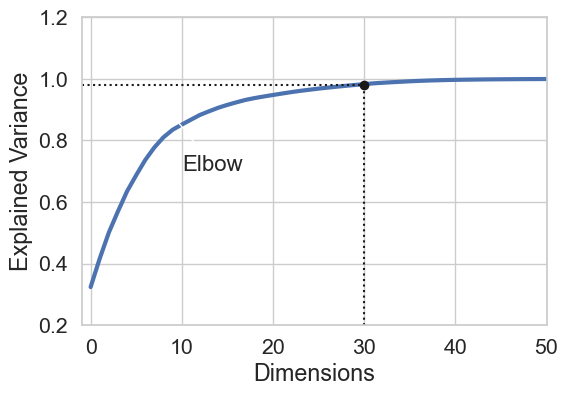

In [56]:
# elbow method pca
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([-1, 50, 0.2, 1.2])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [-1, 0.98], "k:")
plt.plot([-1, d], [0.98, 0.98], "k:")
plt.plot(d, 0.98, "ko")
plt.annotate("Elbow", xy=(8, 0.92), xytext=(10, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

Bisa terlihat ternyata mengurangi dimensi data menjadi 30 masih cukup masuk akal. Karena data hanya kehilangan 2% informasi namun bisa mengurangi dimensinya hingga 33 dimensi. Oleh karena itu, akan dibuang saja data yang berlebih dan diambil sebanyak 30 kolom saja.

In [57]:
# digunakan pca 0.9
pca = PCA(n_components=0.98)
df_reduced = pd.DataFrame(pca.fit_transform(X_train_balanced))
pca.n_components_

30

In [58]:
df_reduced

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,-0.740055,-0.381491,-0.141945,-0.259202,-0.105669,0.096908,0.129363,-0.388179,-1.001015,-0.707421,0.350724,-0.502001,0.216352,-0.015609,0.184976,0.130374,-0.558068,0.054194,0.374675,0.758730,-0.538030,0.049834,-0.136361,-0.163327,0.192515,0.013499,0.868422,0.104656,0.086073,0.196634
1,-0.349410,0.574188,-2.052169,-0.503366,-0.877667,0.335338,-0.115192,1.216024,-0.839701,-0.622646,-0.534210,0.114169,0.321597,0.371280,-0.494043,-0.372628,0.049021,-0.183881,0.385351,-0.054967,0.053118,0.121414,-0.056632,-0.181874,0.188575,-0.050628,0.871896,0.117949,0.142768,0.212600
2,-0.233139,0.931186,-2.744903,-0.307494,-1.300902,0.411761,-0.134402,1.174979,0.313278,-0.592227,-0.463490,0.198953,0.277335,-0.094303,0.271490,-0.381111,-0.152687,0.117893,0.485891,0.856304,-0.486180,0.130777,-0.103577,-0.171895,0.004893,0.087389,-0.223729,-0.034098,0.422307,-0.050088
3,13.137859,2.321639,1.886533,1.142860,-0.761315,0.132458,-0.071891,0.454864,0.037684,-0.178591,-0.512765,0.011444,-0.107878,-0.963721,0.066717,-0.766602,-0.248540,-0.353497,-0.233502,-0.091703,0.058025,0.304533,0.076720,-0.000141,-0.005003,-0.125713,0.022126,-0.074370,-0.240962,-0.150459
4,-0.513899,0.626656,-1.735669,-0.415021,-0.748345,0.186124,0.186718,-0.570341,-0.419497,0.662194,-0.643217,0.789995,-0.257662,0.607620,-0.755214,0.363430,-0.502987,-0.178269,0.604157,-0.048416,-0.048573,-0.095738,-0.043200,-0.159425,-0.243781,-0.665948,-0.212883,-0.126735,0.086163,-0.075523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967875,-0.480686,1.569561,1.098348,-0.921959,0.414607,0.079677,-0.025726,-0.335366,-0.760754,0.623537,-0.615011,0.289184,0.594559,-0.006824,-0.037768,0.337665,-0.064791,0.125012,0.166118,0.066421,-0.104508,0.046983,-0.207556,0.836932,-0.326304,0.069582,0.046324,-0.170378,-0.434100,-0.241731
1967876,-0.262667,2.291318,2.025782,-0.484882,0.142893,0.215928,-0.150621,-0.216147,1.415382,0.620479,-0.366052,-0.735920,-0.217604,0.329466,0.531762,-0.103164,-0.040190,-0.325182,0.449098,-0.257065,-0.081803,-0.896488,-0.246753,-0.077705,0.178452,0.257065,0.847451,-0.144574,-0.374179,-0.020625
1967877,-0.610195,0.298171,-1.131763,0.418699,-1.003345,0.119567,0.367092,-1.295008,-0.642481,0.818002,0.453018,-0.477996,0.038842,0.368723,0.519855,-0.422010,0.347616,-0.081459,-0.273656,-0.090159,-0.011149,0.017813,0.018344,0.050991,0.032864,-0.026766,0.016156,0.025441,-0.047233,-0.110838
1967878,5.764533,-1.326480,1.423059,-1.179222,0.805564,0.169543,-0.038037,0.378700,-0.271050,0.363106,0.482387,0.449337,-0.859067,-0.013885,-0.140877,0.010326,0.980036,0.287231,-0.426931,0.015577,-0.232189,0.217424,-0.437390,-0.425620,-0.370423,0.175966,-0.036354,-0.159852,-0.270446,-0.126136


# Modelling

Untuk modelling, akan digunakan metode Logistic Regression. Dasar pemilihan metode ini adalah karena perhitungannya yang simpel, sehingga model ini bisa melakukan klasifikasi yang cukup baik tanpa waktu yang lama. Berhubung waktu sudah banyak habis di bagian preprocessing, saya sudah yakin sekali bahwa untuk modelling akan menghabiskan waktu lebih banyak lagi jika digunakan model-model yang lain yang lebih berat.

### Logistic Regression

In [59]:
LR = LogisticRegression(random_state= 69)
# cross validation logistic regression
kfold = KFold(n_splits=10)
scoreLR_train = cross_val_score(LR, df_reduced, y_train_balanced, scoring="precision_macro", cv=kfold)


print("Cross Validation array       :",scoreLR_train)
print("Cross Validation score       :",scoreLR_train.mean())
print("Std Dev Cross Validation     :",scoreLR_train.std())

Cross Validation array       : [0.46679325 0.46680304 0.46850711 0.51701496 0.33333333 0.33333333
 0.48286479 0.33333333 0.33333333 0.33333333]
Cross Validation score       : 0.4068649814836215
Std Dev Cross Validation     : 0.07478450704339477


In [60]:
modelLR = LR.fit(df_reduced,y_train_balanced)

Benar saja, untuk modelling ini menghabiskan waktu 4 menit di baseline modelnya saja. Untuk Machine Learning ini cukup lama. Akan lebih lama lagi pastinya jika ingin dilakukan Tuning. Berdasarkan pertimbangan tadi, akan saya cukupkan saja dahulu sampai disini.

### Model Evaluation

Sebelum evaluasi model, akan di preprocess dahulu data test nya dan selanjutnya akan di gunakan model yang sudah dilatih untuk diimplementasikan ke data test.

In [61]:
X_test_prep = final_prep.transform(X_test)

In [62]:
X_test_prepo = pd.DataFrame(X_test_prep)

In [63]:
X_test_prepo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.088889,0.565601,0.00,0.049334,0.000000,0.072945,-1.398715,-0.364668,-0.063905,1.379766,1.378481,-0.106806,-0.112388,-0.619814,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.311111,0.391275,0.00,0.333864,0.000000,0.093237,-0.998643,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.525242,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.666667,0.052448,0.00,0.587739,0.000000,0.158446,1.135073,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.221336,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.241902,0.248751,0.00,0.000000,0.091667,0.602049,-0.198500,0.801230,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,1.846102,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0
4,0.167271,0.342990,0.25,0.033101,0.000000,0.097567,1.135073,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.505064,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177471,0.400000,0.180653,0.00,0.267207,0.000000,0.086689,-0.198500,-0.364668,-0.063905,1.379766,3.691431,-0.106806,-0.112388,-0.555762,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
177472,0.577778,0.243590,0.75,0.594674,0.000000,1.000000,1.135073,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,4.039839,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0
177473,0.444444,0.399267,0.00,0.346051,0.000000,0.330886,-0.731928,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,0.582332,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0
177474,0.351111,0.155012,1.00,0.466313,0.241667,0.165008,-0.998643,-0.364668,-0.063905,-0.335796,-0.392370,-0.106806,-0.112388,-0.190752,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0


In [64]:
X_test_red = pd.DataFrame(pca.transform(X_test_prepo))

In [65]:
X_test_red

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,-1.066082,0.608200,2.860976,-0.800055,0.930435,0.094340,-0.132738,0.232741,-1.261109,-0.140413,-0.515233,0.973404,-0.456044,-0.015759,0.096439,0.148007,0.033785,0.906319,-0.465067,0.213188,0.903123,-0.061154,-0.422387,-0.547892,-0.417770,0.449944,-0.031527,-0.186487,0.022613,0.333536
1,-0.886850,-0.895390,0.693321,-0.823900,0.553816,0.043211,0.109753,-0.414647,-1.184100,-0.358724,0.294494,-0.525372,0.288350,0.395495,-0.743599,-0.183013,-0.310966,-0.072532,-0.224497,0.472401,0.833478,-0.183433,0.876980,-0.171453,-0.264355,0.159836,-0.001802,-0.148931,-0.043031,0.210870
2,-0.936921,-1.394831,1.405988,1.441534,-0.685735,0.078332,0.296877,-0.559636,-1.285644,-0.242337,0.592999,0.285132,-0.716264,0.458115,0.759377,-0.177916,-0.219162,-0.390537,-0.226852,-0.157607,-0.031582,0.277835,0.085805,0.013779,0.057162,0.168181,0.013003,-0.015116,-0.038187,0.045349
3,-0.438421,-0.100999,-1.429925,-0.072650,-0.096455,-0.185179,-0.571982,1.752511,0.199775,1.026645,0.501024,-0.364807,0.086620,0.376138,0.482720,-0.811460,0.210516,-0.093478,0.438625,-0.210716,0.025721,-0.773096,-0.249800,-0.087520,0.218653,0.202647,0.845803,0.088601,0.174233,0.204180
4,-0.571298,0.324010,-1.454245,0.201940,-1.078430,0.236943,0.245773,-1.163752,1.527231,0.573959,0.621582,0.702137,-0.876053,-0.642305,-0.216688,-0.153522,-0.601597,-0.190790,-0.221636,-0.120092,-0.111791,0.362073,0.077943,-0.003096,0.111979,0.298834,0.036510,-0.011221,-0.023117,-0.044443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177471,-0.998336,2.631915,2.885333,0.173127,0.184332,0.117660,-0.127133,-0.027302,-0.856452,-0.835866,-0.103034,-0.771972,-1.346210,-0.081348,0.194648,-0.008359,-0.455809,0.572092,0.528299,-0.249472,0.113545,-0.145455,-0.062443,-0.170279,-0.062261,-0.822252,0.814166,0.086355,0.148303,0.305797
177472,-0.269995,-0.281087,-1.382450,1.256182,-2.106581,0.606177,-0.290786,3.413341,0.071517,0.283879,0.754454,-0.351168,0.158777,0.462796,0.671059,-0.620722,-1.233372,-0.340035,-0.178868,-0.375979,-0.034011,-0.457989,-0.065930,0.072282,0.039492,0.203955,0.012333,-0.137359,-0.321291,-0.236503
177473,-0.665000,-0.767740,-0.056425,-0.888816,-0.066424,0.344576,-0.117680,0.792249,0.811242,0.537859,-0.299948,0.937446,-0.553891,0.300628,0.649329,-0.952409,0.669872,-0.100622,0.114550,0.023855,0.104662,0.395973,-0.142469,0.812314,-0.275348,0.200555,0.044271,-0.012123,0.024861,0.063288
177474,-0.621517,-0.130266,-0.707869,-1.060565,0.072103,0.222373,-0.090991,0.255714,0.072723,-0.963866,-0.588594,1.109194,-0.541044,-0.008321,0.408201,0.372286,-0.471041,0.707913,0.047540,-0.333687,-0.081626,0.029883,0.900870,-0.076505,-0.168431,0.242813,0.026651,-0.272348,-0.595888,-0.270180


In [66]:
df_reduced.shape

(1967880, 30)

In [67]:
X_test_red.shape

(177476, 30)

In [68]:
# performance logreg
y_pred_train_log = modelLR.predict(df_reduced)
y_pred_test_log = modelLR.predict(X_test_red)
print('recall score train : ',recall_score(y_train_balanced,y_pred_train_log,average='macro'))
print('recall score test : ',recall_score(y_test,y_pred_test_log,average='macro'))

recall score train :  0.675486818301929
recall score test :  0.6479942213852025


confusion matrix LogReg Train Set


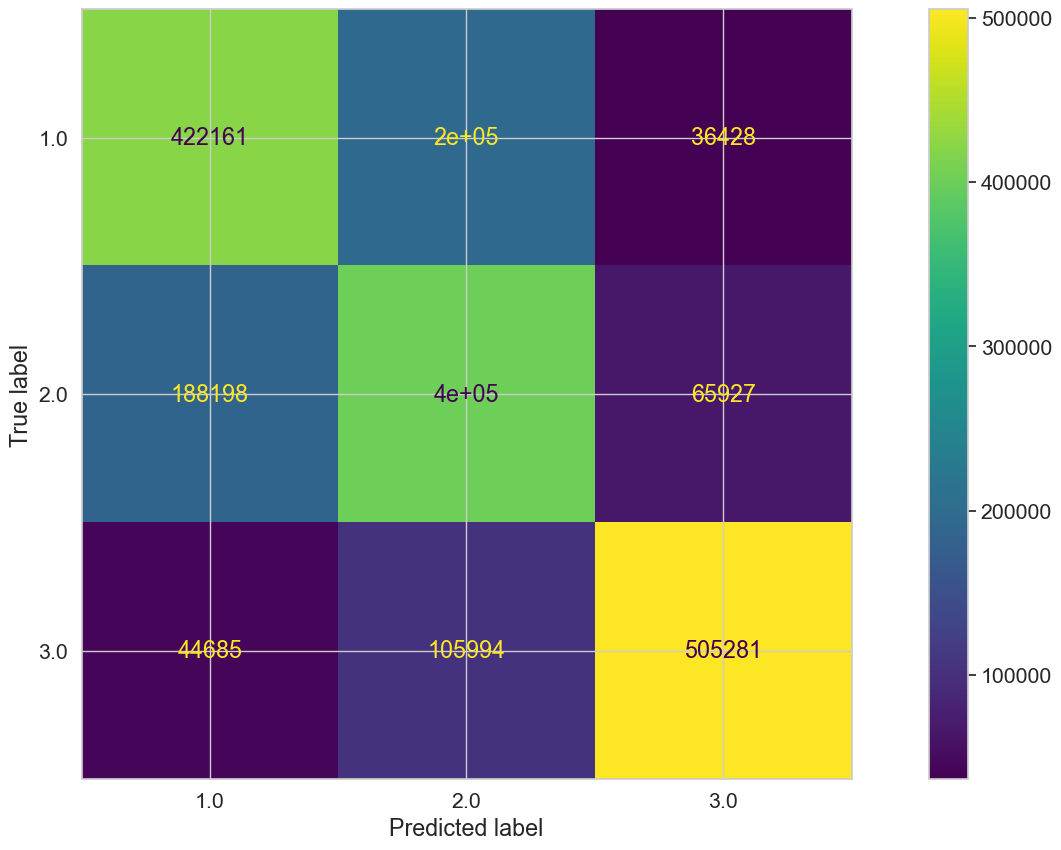

                                           
confusion matrix LogReg Test Set


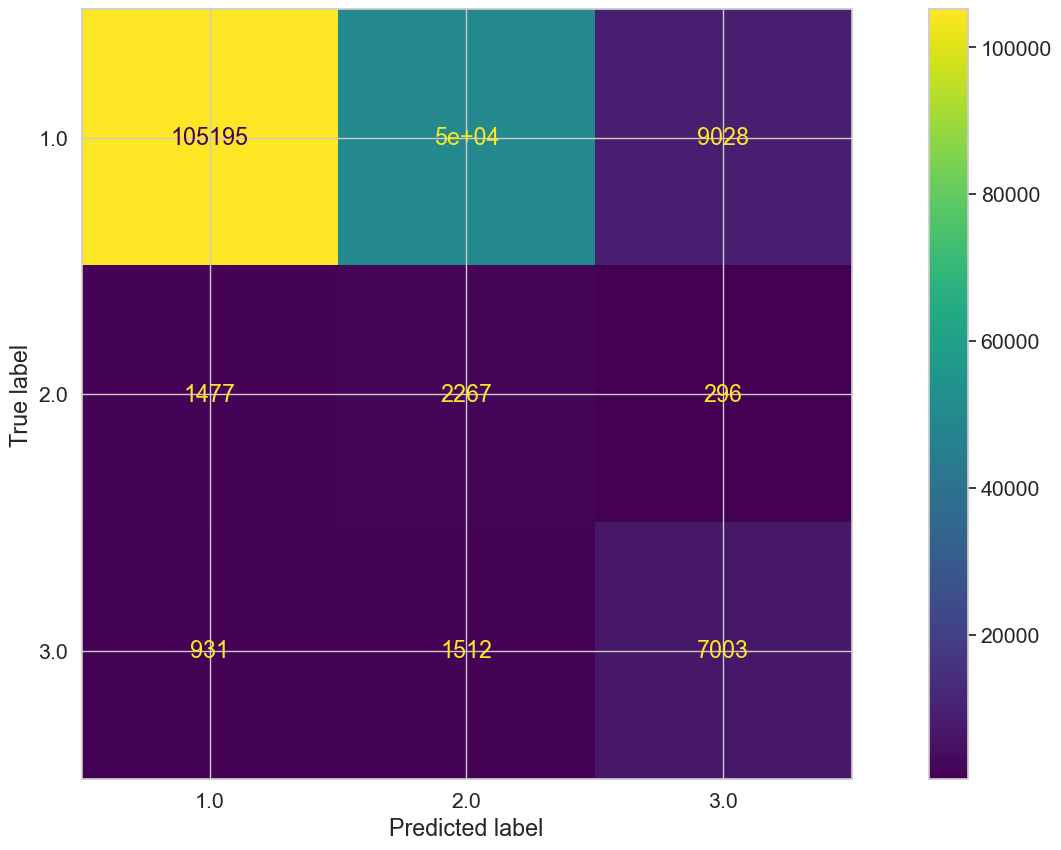

In [69]:
# confusion matrix logreg
print('confusion matrix LogReg Train Set')
lr = confusion_matrix(y_train_balanced,y_pred_train_log, labels=modelLR.classes_)
displr = ConfusionMatrixDisplay(confusion_matrix=lr,display_labels=modelLR.classes_)
displr.plot()
plt.show()
print('                                           ')
print('confusion matrix LogReg Test Set')
lr2 = confusion_matrix(y_test,y_pred_test_log, labels=modelLR.classes_)
displr2 = ConfusionMatrixDisplay(confusion_matrix=lr2,display_labels=modelLR.classes_)
displr2.plot()
plt.show()

In [70]:
# classification report
print('classification report Logistic Regression Train Set')
print(classification_report(y_train_balanced,y_pred_train_log))
print('                                  ')
print('classification report Logistic Regression Test Set')
print(classification_report(y_test,y_pred_test_log))

classification report Logistic Regression Train Set
              precision    recall  f1-score   support

         1.0       0.64      0.64      0.64    655960
         2.0       0.57      0.61      0.59    655960
         3.0       0.83      0.77      0.80    655960

    accuracy                           0.68   1967880
   macro avg       0.68      0.68      0.68   1967880
weighted avg       0.68      0.68      0.68   1967880

                                  
classification report Logistic Regression Test Set
              precision    recall  f1-score   support

         1.0       0.98      0.64      0.77    163990
         2.0       0.04      0.56      0.08      4040
         3.0       0.43      0.74      0.54      9446

    accuracy                           0.64    177476
   macro avg       0.48      0.65      0.47    177476
weighted avg       0.93      0.64      0.75    177476



In [71]:
y_test.value_counts()

1.0    163990
3.0      9446
2.0      4040
Name: loan_category, dtype: int64

### Model Evaluation Conclusion

---

---

Untuk melakukan evaluasi model ini, saya menggunakan hasil dari prediksi test dan trainnya, di mana saya fokus pada nilai **recall**  model, yang merupakan penilaian mengenai semua prediksi benar dari kelas yang bersangkutan. Berikut adalah hasil evaluasi untuk setiap recall nya:

`1`
* Nilai recall 0.68 di training, dan 0.68 di test (BEST FIT)
* Pada dataset test, confusion matrix memperlihatkan model berhasil memprediksi 110721 true positive dari 163990. Yang artinya sudah cukup baik memprediksi kelas 1. Hal ini mungkin dikarenakan banyaknya data latihan yang sudah di jalani model untuk kelas ini.

`2`
* Nilai recall 0.63 di training, dan 0.52 di test (OVER FIT)
* Pada dataset test, confusion matrix memperlihatkan model berhasil memprediksi 2085 true positive dari 4040. Yang artinya belum cukup baik memprediksi kelas 2. Hal ini mungkin dikarenakan sedikitnya data latihan yang sudah di jalani model untuk kelas ini.

`3`
* Nilai accuracy 0.77 di training, dan 0.75 di test (GOOD FIT)
* Pada dataset test, confusion matrix memperlihatkan model berhasil memprediksi 7039 true positive dari 9446. Yang artinya sudah cukup baik memprediksi kelas 3. Hal ini mungkin dikarenakan sedikitnya data latihan yang sudah di jalani model untuk kelas ini.

Pada hasil evaluasi di atas, ditemukan bahwa semua model memberikan hasil yang belum cukup baik. Hal ini dapat terjadi karena data memiliki kompleksitas yang tinggi.

Berdasarkan hasil evaluasi di atas, model Tree Classifier dengan Hyperparameter Tuning adalah pilihan terbaik karena cenderung memiliki performa yang lebih seimbang dalam memprediksi kelas positif dan negatif.

# Conclusion

Akhirnya sudah sampai ke bagian kesimpulan. Pada bagian ini akan saya uraikan beberapa summary dari segi data, permodelan, dan juga saran secara bisnis. Berikut adalah uraiannya:

---
---
**Data Summary & Improvement**
-
Secara data, kolom yang ada semuanya terlihat berguna untuk prediksi target. Data target prediksi juga tidak setara(imbalance) dan jumlah baris data nya ini termasuk besar. Oleh karena itu, saat pengerjaan notebook ini saya menghabiskan waktu yang lama saat proses pemahaman data, seleksi fitur, dan juga modelling. Banyaknya kolom dan baris ini cukup merepotkan karena keterbatasan hardware. Jujur saja, data ini sangat menarik untuk dilakukan analisa mendalam seperti yang sudah saya lakukan pada bagian Exploratory Data Analysis. Masih banyak sekali yang dapat diamati lalu dibuatkan visualisasinya. Mungkin untuk improvement kedepannya, hal yang pertama akan saya lakukan adalah hal ini. Sebagai summary, akan saya sampaikan kembali bahwa dari data terlihat bahwa dari keseluruhan debitur, perbandingan dari yang beresiko dengan yang tidak beresiko sangat jauh. Hal ini saya sadari perbedaannya dengan kenyataannya di Indonesia. Informasi yang pernah saya dapatkan dari internet menyatakan bahwa untuk di Indonesia, bank atau penyedia layanan kredit seperti ini sangat menguntungkan. Hal ini karena standar gaji yang kecil, namun ego yang tinggi menjadikan kita sebagai salah satau bangsa paling konsumtif di dunia. Secara datanya sendiri, jumlah debitur yang beresiko pasti lebih banyak. **Oleh karena itu, data apapun yang kita gunakan sebagai dasar dari model tidak akan bisa diimplementasikan di Indonesia.** Dari segi manapun jika menggunakan pandangan kredit, Indonesia tergolong anomali. Mulai dari mental yang tidak malu jika berhutang, sampai tidak malu jika tidak bayar hutang itu semuanya ada di Indonesia. Saya setuju soal penagihan hutang yang keras untuk kasus yang sudah sangat berat.
___
---
**Model Summary & Improvement**
-
Dari hasil model, sudah terlihat sekali bahwa model memiliki performa yang kurang. Namun, jika diperhatikan kembali hasilnya, jumlah klasifikasinya sudah cukup besar untuk kelas yang memang beresiko (3). Hal ini menguntungkan karena tim resiko kredit setidaknya tidak perlu lagi menghabiskan waktu dalam menyaring list debitur. Perlu diingat juga, bahwa model ini hanya dapat melakukan penyaringan secara makro. Untuk mendetilnya diperlukan pengawasan juga dari seorang manusia. Intinya, model hanya bisa melakukan hal yang membosankan, bukan melakukan analisa mendetil. Sebagai improvement, saya melihat beberapa peluang pemanfaatan feature selection untuk mengurangi beratnya operasi model. Perlu dilakukan validasi juga dengan membandingkan hasil model Logistic Regression dengan model klasifikasi lainnya. Hal- hal yang disebutkan cukup penting namun, berhubung keterbatasan waktu, saya hanya bisa sampaikan sebagai masukan saja.
___
---
**Business Improvement**
-
Secara keseluruhan, analisis ini menggarisbawahi kompleksitas pembuatan model risiko kredit dan ketergantungannya pada lanskap kredit lokal. Insight yang diperoleh dari dataset dan kinerja model menunjukkan adanya peluang untuk perbaikan dan validasi. Meskipun eksplorasi ini memberikan wawasan yang berharga, analisis, validasi, dan adaptasi tambahan diperlukan untuk menerjemahkan temuan ke dalam strategi yang dapat ditindaklanjuti untuk manajemen risiko kredit dalam konteks tertentu. Diperlukan data lebih yang dapat menafsirkan behaviour nasabah dalam melakukan pembayaran, bisa digunakan data-data seperti itu untuk membantu pengambilan keputusan, bahkan penentuan SOP. Sebagai contoh, saya memutuskan untuk membuat kolom fitur baru berisikan rank dari kebiasaan masing-masing nasabah dalam melakukan pembayaran.

Untuk rank nya akan meliputi :
- 6 = Nasabah yang melakukan pembayaran dari bulan April hingga September tanpa absen.
- 5 = Nasabah yang melakukan pembayaran dari bulan May hingga September tanpa absen.
- 4 = Nasabah yang melakukan pembayaran dari bulan June hingga September tanpa absen.
- 3 = Nasabah yang melakukan pembayaran dari bulan July hingga September tanpa absen.
- 2 = Nasabah yang melakukan pembayaran dari bulan August hingga September tanpa absen.
- 1 = Nasabah yang hanya melakukan pembayaran pada bulan September.
- 0 = Nasabah yang tidak melakukan transaksi selama 6 bulan.
Setelah dibuatkan ranking tersebut, bisa digunakan untuk modeling, atau bisa juga digunakan sebagai standar tertentu dalam melakukan penagihan. Untuk rank 6 tidak perlu ditagih, rank 5 dan 4 ditelfon saja, sisanya perlu disesuaikan juga treatment nya sesuai dengan standar.